# 비데/정수기 렌탈 고객 해지 여부 예측하기
- 과제 목표 : 렌탈 해지 예상 고객 예측, 해지 방지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from datetime import datetime, timedelta

np.random.seed(2023)


In [2]:
# 모든 칼럼 보기
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.font_manager as fm
# # 설치되어 있는 폰트 확인하기
fm.get_font_names()

['Maiandra GD',
 'Wingdings 3',
 'Dubai',
 'MV Boli',
 'Showcard Gothic',
 'HancomEQN',
 'Footlight MT Light',
 'cmtt10',
 'Wingdings 2',
 'Californian FB',
 'Pristina',
 'Lucida Console',
 'Comic Sans MS',
 'Copperplate Gothic Light',
 'Brush Script MT',
 'Magneto',
 'HYGothic-Medium',
 'Haettenschweiler',
 'Myanmar Text',
 'Century Schoolbook',
 'Eras Light ITC',
 'Wingdings',
 'Eras Demi ITC',
 'Imprint MT Shadow',
 'Calibri',
 'Century Gothic',
 'Nirmala UI',
 'Niagara Solid',
 'HCR Dotum',
 'Britannic Bold',
 'Times New Roman',
 'Consolas',
 'HYGraphic-Medium',
 'MS Reference Sans Serif',
 'cmr10',
 'STIXSizeFiveSym',
 'Segoe UI',
 'Gill Sans MT Condensed',
 'Yu Gothic',
 'Elephant',
 'Gloucester MT Extra Condensed',
 'MoeumT R',
 'Viner Hand ITC',
 'STIXSizeFourSym',
 'Malgun Gothic',
 'Niagara Engraved',
 'DejaVu Sans Mono',
 'Rockwell Extra Bold',
 'Ami R',
 'Mongolian Baiti',
 'Castellar',
 'Tw Cen MT Condensed',
 'Lucida Calligraphy',
 'HYPost-Medium',
 'OCR A Extended',
 'Le

In [4]:
import matplotlib
# NanumGothicCoding 폰트 설정하기
plt.rc('font',family = 'Malgun Gothic')

# 시각화할 때 음수 표시 설정하기
matplotlib.rcParams['axes.unicode_minus'] = False  

In [5]:
# 자동 완성 기능 설정하기
%config Completer.use_jedi = False

# 1.기초 데이터 다루기/전처리

## 1-1. 데이터 획득하기

### 1) 데이터 파일 설명
- bidet_w_disp_termination_train/test.csv : 고객별 비데, 정수기 유지,해지 정보
- bidet_w_disp_voc_train/test.csv : 고객별 voc 발생건수

In [6]:
# 파일 읽어서 데이터프레임에 저장하기
train_termination = pd.read_csv('./데이터/bidet_w_disp_termination_train.csv')
test_termination = pd.read_csv('./데이터/bidet_w_disp_termination_test.csv')
train_voc = pd.read_csv('./데이터/bidet_w_disp_voc_train.csv')
test_voc = pd.read_csv('./데이터/bidet_w_disp_voc_test.csv')

## 1-2. 데이터 구조 확인

### 1) 데이터 설명
![Alt text](image-1.png)

### 2) info 함수를 활용하여 데이터프레임 정보 확인하기

In [7]:
# train_termination 데이터프레임의 기본적인 형태와 정보 확인하기
train_termination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            54990 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [8]:
# train_voc 데이터프레임의 기본적인 형태와 정보 확인하기
train_voc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74529 entries, 0 to 74528
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74529 non-null  object
 1   voc_type_cd  74529 non-null  int64 
 2   voc_type_nm  74529 non-null  object
 3   voc_cnt      74529 non-null  int64 
 4   day_cnt      74529 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


### 3) head 메소드를 활용하여 데이터프레임 살펴보기

In [9]:
# 실제 데이터 확인하기
train_termination.head()

train_voc.head()

,id,voc_type_cd,voc_type_nm,voc_cnt,day_cnt
0,E1000001,6,청구 수/미납,1,1
1,E1000002,9,해지,1,1
2,E1000003,12,업무협조,1,1
3,E1000004,7,AS,1,1
4,E1000004,8,품질,1,1


## 1-3. 데이터프레임 합치기

### 1)피벗테이블(pivot_table)로 집계하기

In [10]:
# values: 계산 대상, aggfunc: 계산 유형, index: 행 인덱스, columns: 열 인덱스
train_voc_pivot = train_voc.pivot_table(values='voc_cnt', aggfunc='sum', 
                                        index='id', columns='voc_type_nm', 
                                        fill_value=0 # 값이 존재하지 않는 셀을 채울지(default = NaN)
                                        )

train_voc_pivot 

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
id,,,,,,,,,,,,,
E1000001,0,0,0,0,0,0,0,0,0,1,0,0,0
E1000002,0,0,0,0,0,0,0,0,0,0,0,1,0
E1000003,0,0,0,0,0,1,0,0,0,0,0,0,0
E1000004,1,0,0,0,0,0,0,0,0,0,1,0,0
E1000005,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
E1054996,0,0,0,0,0,0,0,0,0,0,1,0,0
E1054997,0,0,0,0,0,0,0,0,0,0,0,1,0
E1054998,0,0,0,0,0,2,0,0,0,0,0,0,0


In [11]:
# VOC건수(voc_cnt)별, VOC발생일수(day_cnt)별, train/test 각각 피벗테이블 생성하기
train_voc_cnt = train_voc.pivot_table(values='voc_cnt',aggfunc='sum',
                                      index='id', columns='voc_type_nm', fill_value=0)

train_day_cnt = train_voc.pivot_table(values='day_cnt',aggfunc='sum',
                                      index='id',columns='voc_type_nm',fill_value=0)

test_voc_cnt = test_voc.pivot_table(values='voc_cnt',aggfunc='sum',
                                    index='id',columns='voc_type_nm',fill_value=0)

test_day_cnt = test_voc.pivot_table(values='day_cnt',aggfunc='sum',
                                    index='id',columns='voc_type_nm',fill_value=0)

In [12]:
# pivot_table로 집계 전 VOC건수 확인하여 검증하기
train_voc['voc_cnt'].sum(), train_voc['day_cnt'].sum(), test_voc['voc_cnt'].sum(), test_voc['day_cnt'].sum()

(90752, 82858, 8469, 7702)

In [13]:
train_voc_cnt.sum()

voc_type_nm
AS            2398
가입            7146
개통            1072
대리점문의            2
변경/조회        11807
업무협조         18285
이용            6823
정보보호/언론보도      355
채널            4694
청구 수/미납      12775
품질            6490
해지           16894
혜택            2011
dtype: int64

In [14]:
# pivot_table로 집계 후 VOC건수 확인하여 검증하기
train_voc_cnt.sum().sum(), train_day_cnt.sum().sum(), test_voc_cnt.sum().sum(), test_day_cnt.sum().sum()

(90752, 82858, 8469, 7702)

### 2)데이터프레임 병합하기

In [15]:
# 인덱스인 id의 순서를 동일하게 맞춰주고 drop해준다.
train_voc_cnt = train_voc_cnt.reset_index(drop=True)
train_day_cnt = train_day_cnt.reset_index(drop=True)
test_voc_cnt = test_voc_cnt.reset_index(drop=True)
test_day_cnt = test_day_cnt.reset_index(drop=True)

In [16]:
# 결과 확인
train_voc_cnt

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0,0,0,0,0,0,0,0,0,0,1,0,0
54996,0,0,0,0,0,0,0,0,0,0,0,1,0
54997,0,0,0,0,0,2,0,0,0,0,0,0,0
54998,0,0,0,0,0,0,0,0,0,1,0,1,0


In [17]:
# 결과 확인
train_day_cnt

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0,0,0,0,0,0,0,0,0,0,1,0,0
54996,0,0,0,0,0,0,0,0,0,0,0,1,0
54997,0,0,0,0,0,1,0,0,0,0,0,0,0
54998,0,0,0,0,0,0,0,0,0,1,0,1,0


In [18]:
# 데이터프레임을 합쳤을 때 칼럼명이 중복되지 않도록 변경하기(prefix 붙이기)
for col in train_voc_cnt.columns:
    train_day_cnt.rename(columns={col:'day_cnt_'+col}, inplace=True)
    train_voc_cnt.rename(columns={col:'voc_cnt_'+col}, inplace=True)

for col in test_voc_cnt.columns:
    test_voc_cnt.rename(columns={col:'voc_cnt_'+col},inplace=True)
    test_day_cnt.rename(columns={col:'day_cnt_'+col},inplace=True)

In [19]:
train_termination.head()

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.000,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.000,34460,0,_,R06
2,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.000,0,28600,0,_
3,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,218303.001,34747,55000,P36,R11
4,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,310095.999,59856,54082,R27,R22


In [20]:
train_voc_cnt.head()

voc_type_nm,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_대리점문의,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
train_day_cnt.head()

voc_type_nm,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_대리점문의,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


In [22]:
# pd.concat([병합 대상 list], axis=1) 
train_data=pd.concat([train_termination,train_voc_cnt,train_day_cnt],axis=1)
test_data=pd.concat([test_termination,test_voc_cnt,test_day_cnt],axis=1)

# 결과 확인
train_data.shape,  test_data.shape

((55000, 48), (5000, 46))

In [23]:
# train_data의 칼럼중에서 test_data에 없는 칼럼 찾기
[x for x in train_data.columns.tolist() if x not in test_data.columns.tolist()]

['voc_cnt_대리점문의', 'day_cnt_대리점문의']

In [24]:
# train_data에만 존재하는 2개 칼럼 삭제하기
train_data.drop(['voc_cnt_대리점문의','day_cnt_대리점문의'],axis=1,inplace=True)

# 삭제 후 결과 확인하기
train_data.shape, test_data.shape

((55000, 46), (5000, 46))

## 1-4. 결측치 처리하기

### 1)결측치 확인하기

In [25]:
train_data.isnull().sum() # w_disp_cnt : 10개
train_data.isnull().sum().sum() # 10개
# test_data.isnull().sum()
# test_data.isnull().sum().sum()  # 0개

10

In [26]:
train_data[train_data['w_disp_cnt'].isnull()]
# 정수기 계약 수가 모두 빈칸

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
50,E1000051,Y,20200515,0,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,177563.001,29793,74708,R34,P05,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
51,E1000052,N,20150416,0,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,83873.001,16792,38106,P27,R11,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0
52,E1000053,N,20121022,1,NaN,10001,M,N,Y,N,N,N,_,_,_,_,N,50318.001,16772,0,_,R01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
53,E1000054,N,20160210,2,NaN,10001,F,N,Y,N,N,N,_,_,_,_,N,7809.000,2603,0,_,P23,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0
54,E1000055,N,20161028,1,NaN,10001,M,N,Y,N,N,N,_,_,_,_,Y,12582.000,4124,0,_,P15,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
55,E1000056,Y,20130515,3,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,318153.999,35497,32666,P34,R11,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
56,E1000057,Y,20200716,1,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,400389.000,32356,54992,R21,R09,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
57,E1000058,Y,20190209,5,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,337518.000,46443,46200,R19,R13,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
58,E1000059,N,20171023,2,NaN,10001,F,N,Y,Y,Y,Y,_,_,_,_,N,98709.000,32540,0,_,P03,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
59,E1000060,Y,20180927,1,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,367350.000,33403,50600,R14,R08,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### 2)결측치 대체하기

In [27]:
# 평균값(mean), 중위값(median), 최빈값(mode) 확인하기
print("평균값:",train_data['w_disp_cnt'].mean())
print("중위값:",train_data['w_disp_cnt'].median())
print("최빈값:",train_data['w_disp_cnt'].mode())

평균값: 0.7372067648663393
중위값: 1.0
최빈값: 0    1.0
Name: w_disp_cnt, dtype: float64


디스트플롯(Distplot)
- 히스토그램 + 커널 밀도 추정 그래프(kdeplot)
- 분포 + 밀도 함께 확인 가능

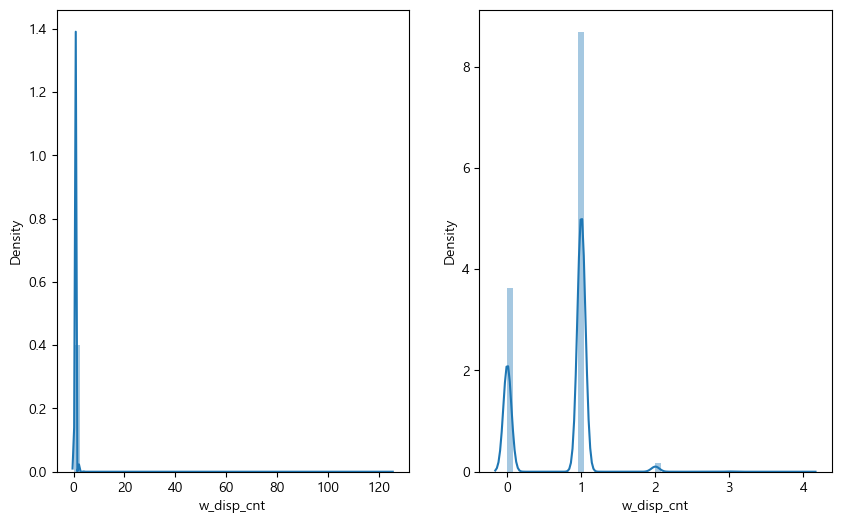

In [28]:
# 그래프의 크기, 옵션 지정하기
fig, ax = plt.subplots(ncols=2, figsize = (10,6))

# distplot 생성
sns.distplot(train_data['w_disp_cnt'], ax=ax[0])

# 10이하로 몰려있는 수치를 잘 보기 위해서
# sns.distplot(train_data[train_data['w_disp_cnt']<10]['w_disp_cnt'], ax=ax[1])
sns.distplot(train_data[train_data['w_disp_cnt']<5]['w_disp_cnt'], ax=ax[1])

plt.show()

In [29]:
# df.fillna("대체값", inplace=True)
train_data['w_disp_cnt'].fillna(train_data['w_disp_cnt'].median(), inplace=True)

# 결측치 제거 결과 확인하기
train_data.isnull().sum().sum(),   test_data.isnull().sum().sum()

(0, 0)

## 1-5. 데이터 유형 변경하기

In [30]:
train_data.info()

# --> new_date와 cust_cd는 각각 날짜, object로 바꿔야하는데, 그렇지 않음..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            55000 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [31]:
# 실제와 데이터 유형이 다른 칼럼 확인하기
train_data.loc[:5,['new_date','cust_cd']]

,new_date,cust_cd
0,20170421,10001
1,20131203,10001
2,20170731,10001
3,20090930,10001
4,20151121,10001
5,20120711,10001


int → datetime

In [32]:
# # 1 번째 방법
# 날짜형식으로 변경하기(y/m/d)
# train_data['new_date'] = pd.to_datetime(train_data['new_date'], format='%Y%m%d')
# test_data['new_date'] = pd.to_datetime(test_data['new_date'], format='%Y%m%d')
# train_data['new_date'].head()

# # 2번째 방법
def GetDateTime(date):
    date = datetime.strptime(str(date), '%Y%m%d')
    return date

train_data['new_date'] = train_data['new_date'].apply(lambda x : GetDateTime(x))
test_data['new_date'] = test_data['new_date'].apply(lambda x : GetDateTime(x))

print('변경 후 타입 : ', test_data['new_date'].dtype)

변경 후 타입 :  datetime64[ns]


int → object

In [33]:
# 고객 코드 -> 범주형 확인
train_data['cust_cd'].value_counts()

# object로 변경하기
train_data['cust_cd'] = train_data['cust_cd'].astype('O')
test_data['cust_cd'] = test_data['cust_cd'].astype('O')

# 확인
print('train 타입 :', train_data['cust_cd'].dtype)
print('test 타입 :', test_data['cust_cd'].dtype)

train 타입 : object
test 타입 : object


## 1-6. 파생 변수 추가
- 업무 담당자의 도메인 지식이 빛을 발하는 부분이다. 
- 이후 데이터 분석이나 AI 모델링에 큰 영향을 줄 수 있다.
---
- 날짜
    - 시간의 흐름에 의미가 있는 데이터이다.
    - 실제 운영 환경에서는 학습 시점과 예측하는 시점이 다르다. 
    - 따라서 데이터의 추출 시점이 다르기 때문에 동일한 날짜라도 x개월 경과한 시점과 y개월 경과한 시점에 날짜의 의미가 다르다.  

### 1)날짜데이터 -> 경과시간 데이터로 파생 변수 만들기

In [34]:
print(train_data['new_date'].max())
print(test_data['new_date'].max())

2020-08-31 00:00:00
2020-09-30 00:00:00


train_data : ~ 20/ 8/ 31 까지
test_data : ~ 20/ 9/ 30 까지

1개월의 시점 차이가 발생함
-> 기준점을 각각 8.31, 9.30로 잡고 가입기간을 산정하여 대체한다.

In [35]:
# datetime까지 뺄셈, 덧셈이 가능
# days는 timedelta64형이므로 가입기간을 int형으로 변경하는 작업이 필요함
# (.dt.days붙임)하여 int로 바꾸고 파생 변수 추가하기

train_data['join_period'] = (datetime(2020,8,31,0,0) - train_data['new_date']).dt.days
test_data['join_period'] = (datetime(2020,9,30,0,0) - test_data['new_date']).dt.days

train_data['join_period'].head()

0    1228
1    2463
2    1127
3    3988
4    1745
Name: join_period, dtype: int64

### 2)해지 경과 기간 코드(trmn_eperd_cd)을 이용하여 파생 변수 추가하기
- 특정 상품의 해지가 발생하면, 고객이 보유한 다른 상품도 해지할 가능성이 있다.
- 장기 미납자에 대한 해지 처리나 결합으로 묶여 있던 상품이 타사로 일괄 이동하는 경우가 있다.

In [36]:
# 대상 칼럼들
teperd_cols = ['w_disp_trmn_eperd_cd', 'bidet_trmn_eperd_cd']

# 대상 칼럼들 실제 데이터 확인
train_data[teperd_cols]
 # 상품 해지 경과 기간 코드 R37...

,w_disp_trmn_eperd_cd,bidet_trmn_eperd_cd
0,_,_
1,_,_
2,_,_
3,_,_
4,_,_
...,...,...
54995,_,_
54996,_,R37
54997,_,_
54998,_,_


In [37]:
# train_data['w_disp_trmn_eperd_cd'].value_counts()
train_data['bidet_trmn_eperd_cd'].value_counts()

# 당월 : 0
# 해지 후 경과 기간은 R뒤 두자리 수로 표현
# 해지 하지 않은 경우 : _

_      50971
R37     1697
0        412
R01      141
R02      106
R08       91
R04       91
R11       87
R03       80
R07       78
R12       74
R05       71
R09       65
R06       61
R10       56
R31       51
R18       51
R23       47
R32       47
R19       47
R14       45
R13       45
R20       44
R16       40
R24       39
R25       38
R33       38
R15       38
R36       37
R35       36
R17       35
R26       34
R21       34
R30       33
R34       33
R22       33
R28       30
R27       23
R29       21
Name: bidet_trmn_eperd_cd, dtype: int64

In [38]:
def IntTermination(Rcd):
    if Rcd == '0':
        return 0
    elif Rcd == '_':
        return 38
    else:
        return int(Rcd[1:3])
        
        
# teperd_cols = ['w_disp_trmn_eperd_cd', 'bidet_trmn_eperd_cd']
for column in teperd_cols:
    new_column=column.replace('_trmn_eperd_cd','_teperd')
    train_data[new_column]=train_data[column].apply(lambda x: IntTermination(x))
    test_data[new_column]=test_data[column].apply(lambda x: IntTermination(x))

train_data.iloc[:,-2:]

,w_disp_teperd,bidet_teperd
0,38,38
1,38,38
2,38,38
3,38,38
4,38,38
...,...,...
54995,38,38
54996,38,37
54997,38,38
54998,38,38


### 3)약정잔여기간코드(engt_rperd_cd) 관련 파생 변수 추가하기

In [39]:
# 대상 칼럼 리스트 지정
erperd_cols=['w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']

# 실제값 확인
train_data.loc[:,erperd_cols].head() 

,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,R09,R12
1,_,R06
2,0,_
3,P36,R11
4,R27,R22


In [40]:
# 분호 확인
train_data['bidet_trmn_eperd_cd'].value_counts()

# 범주값 확인하기
train_data['bidet_engt_rperd_cd'].value_counts().index

Index(['_', 'R12', 'R07', 'R06', 'R11', 'R10', 'R09', 'R13', 'R24', 'R08',
       'R23', 'R14', 'R22', 'R05', 'R15', 'R04', 'R21', 'R02', 'R01', 'R30',
       'R20', 'R18', 'R16', 'R03', 'R19', 'R29', 'R17', '0', 'R28', 'R25',
       'P37', 'R26', 'R27', 'P01', '|', 'P02', 'P04', 'P06', 'P03', 'P07',
       'P05', 'P08', 'P09', 'P11', 'P12', 'P10', 'P15', 'P14', 'P13', 'P16',
       'P18', 'P19', 'P22', 'P20', 'P21', 'P17', 'P24', 'P23', 'P26', 'P25',
       'P28', 'P31', 'P32', 'P27', 'P30', 'P29', 'P33', 'P35', 'P36', 'P34',
       'R34'],
      dtype='object')

- 무약정 : _ -> 38로 처리
- 이미 해지됨 : | -> 38로 처리
- 약정 만료 후 기간 : P -> 양수로 처리
- 잔여 약정 기간 : R -> 음수로 처리
- 당월 약정 만료 : 0 

In [41]:
def RemaindPriod(cd):
    if (cd == '_') | (cd == '|'):
        return 38
    elif cd == '0':
        return 0
    elif cd[0] == 'P':
        return int(cd[1:3])
    else: # 잔여 약정
        return -int(cd[1:3])
        
        
# erperd_cols=['w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']
for column in erperd_cols:
    new_column=column.replace('_engt_rperd_cd','_erperd')
    train_data[new_column]=train_data[column].apply(lambda x: RemaindPriod(x))
    test_data[new_column]=test_data[column].apply(lambda x: RemaindPriod(x))

train_data.iloc[:,-2:]

,w_disp_erperd,bidet_erperd
0,-9,-12
1,38,-6
2,0,38
3,36,-11
4,-27,-22
...,...,...
54995,32,38
54996,1,38
54997,38,-18
54998,38,-19


In [42]:
train_data

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,E1000001,Y,2017-04-21,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.000,40393,43560,R09,R12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1228,38,38,-9,-12
1,E1000002,N,2013-12-03,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.000,34460,0,_,R06,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2463,38,38,38,-6
2,E1000003,N,2017-07-31,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.000,0,28600,0,_,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1127,38,38,0,38
3,E1000004,Y,2009-09-30,4,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,218303.001,34747,55000,P36,R11,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3988,38,38,36,-11
4,E1000005,N,2015-11-21,1,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,310095.999,59856,54082,R27,R22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1745,38,38,-27,-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,E1054996,N,2005-09-16,0,1.0,10001,M,Y,N,Y,N,Y,_,_,_,_,Y,127844.001,0,44800,P32,_,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5463,38,38,32,38
54996,E1054997,Y,2013-01-17,0,1.0,10001,F,Y,N,Y,N,Y,R37,_,_,10291,N,99000.000,0,48400,P01,_,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2783,38,37,1,38
54997,E1054998,Y,2019-07-09,4,1.0,10001,F,N,Y,N,N,N,_,_,_,_,N,77882.001,14759,0,_,R18,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,419,38,38,38,-18
54998,E1054999,Y,2019-08-12,3,1.0,10001,M,N,Y,N,N,N,_,_,_,_,N,114221.001,15031,0,_,R19,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,385,38,38,38,-19


In [43]:
train_data['id'].value_counts() # 1:1
del_cols = ['id']

## 1-7. 불필요한 칼럼 삭제하기
- 파생 변수를 추가하면서 불필요하게 된 칼럼
- 단일값이거나 지나치게 데이터가 불균형한 칼럼 -> 과대적합 발생 시키는 원인

In [44]:
# 수치형 데이터 칼럼 담기
num_cols = train_data.select_dtypes(['int64', 'float64']).columns
num_cols

# 범주형 데이터 칼럼 담기
obj_cols = train_data.select_dtypes(['O']).columns
obj_cols

Index(['id', 'status', 'cust_cd', 'sex_cd', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn',
       'bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd', 'w_disp_trmn_why_cd',
       'bidet_trmn_why_cd', 'npay_yn', 'w_disp_engt_rperd_cd',
       'bidet_engt_rperd_cd'],
      dtype='object')

In [45]:
train_data.loc[:, num_cols].describe()

# 0의 비중이 많으므로 0이 데이터의 90% 이상인 칼럼을 삭제 대상으로 지정한다.

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,55000.000000,55000.000000,5.500000e+04,5.500000e+04,5.500000e+04,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,2.596782,0.737255,2.915999e+05,3.441105e+04,4.162946e+04,0.043600,0.129927,0.019491,0.214673,0.332455,0.124055,0.006455,0.085345,0.232273,0.118000,0.307164,0.036564,0.038400,0.125909,0.018055,0.201436,0.284218,0.117691,0.006382,0.075455,0.219764,0.110327,0.272909,0.035927,1858.126418,36.910036,36.868073,14.631273,-0.475927
std,66.479010,1.137088,8.496803e+05,3.833091e+04,3.965128e+05,0.256391,0.366102,0.166522,0.552657,0.885980,0.398879,0.082541,0.387991,0.510258,0.390811,0.621277,0.209654,0.212215,0.348169,0.149002,0.447934,0.580211,0.362700,0.080765,0.316198,0.464854,0.351533,0.518703,0.204719,1616.054444,5.627786,5.708939,26.576813,22.398369
min,0.000000,0.000000,-1.136300e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-37.000000,-34.000000
25%,1.000000,0.000000,1.102485e+05,1.131050e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,748.000000,38.000000,38.000000,-9.000000,-15.000000
50%,1.000000,1.000000,1.994620e+05,3.107550e+04,3.266000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1357.000000,38.000000,38.000000,34.000000,-8.000000
75%,2.000000,1.000000,3.363403e+05,4.804125e+04,4.791800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2517.000000,38.000000,38.000000,38.000000,10.000000
max,5077.000000,125.000000,1.806220e+08,3.092769e+06,6.078027e+07,7.000000,6.000000,5.000000,59.000000,102.000000,14.000000,3.000000,12.000000,9.000000,11.000000,8.000000,6.000000,5.000000,4.000000,5.000000,11.000000,16.000000,11.000000,2.000000,9.000000,7.000000,7.000000,6.000000,6.000000,8396.000000,38.000000,38.000000,38.000000,38.000000


### 1)동일값이 90%이상 차지하는 경우 

In [46]:
# 0이 90%이상인 칼럼 삭제 대상에 추가하기
for col in num_cols:
    if(((train_data[col]==0).sum() / 55000) > 0.9):
        print(col + " : " + str((train_data[col]==0).sum() / 55000))
        del_cols.append(col)

voc_cnt_AS : 0.9651272727272727
voc_cnt_개통 : 0.9838181818181818
voc_cnt_정보보호/언론보도 : 0.9937090909090909
voc_cnt_채널 : 0.9343090909090909
voc_cnt_품질 : 0.9000363636363636
voc_cnt_혜택 : 0.9671818181818181
day_cnt_AS : 0.9651272727272727
day_cnt_개통 : 0.9838181818181818
day_cnt_정보보호/언론보도 : 0.9937090909090909
day_cnt_채널 : 0.9343090909090909
day_cnt_품질 : 0.9000363636363636
day_cnt_혜택 : 0.9671818181818181


In [47]:
train_data.loc[:, obj_cols].describe()

# 0의 비중이 많으므로 0이 데이터의 90% 이상인 칼럼을 삭제 대상으로 지정한다.

,id,status,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
count,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000,55000
unique,55000,2,2,3,2,2,2,2,2,39,39,94,31,2,77,71
top,E1000001,Y,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,_,_
freq,1,31806,53681,28486,32474,44657,41462,33075,38924,50971,51578,51812,51119,44920,22924,10996


In [48]:
# 범주형 칼럼(obj_cols)에 대해 가장 많은 범주의 비중이 90%를 넘는 칼럼 찾기

for column in obj_cols:
    
    # value_count() 반환할 때 가장 빈도가 많은 값부터 내림차순으로 반환하는 것을 이용한다
    if((train_data[column].value_counts().iloc[0]/55000) >0.9):        
        print(column+':'+str(train_data[column].value_counts().iloc[0]/55000))
        del_cols.append(column)  # del_cols에 해당 칼럼 추가하기

cust_cd:0.9760181818181818
bidet_trmn_eperd_cd:0.9267454545454545
w_disp_trmn_eperd_cd:0.9377818181818182
w_disp_trmn_why_cd:0.9420363636363637
bidet_trmn_why_cd:0.9294363636363636


### 2)파생 변수로 대체한 칼럼

In [49]:
temp = ['new_date','w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd', 'bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd']

del_cols.extend(temp)

In [50]:
list(set(del_cols))

['bidet_engt_rperd_cd',
 'day_cnt_품질',
 'day_cnt_채널',
 'voc_cnt_혜택',
 'new_date',
 'day_cnt_AS',
 'bidet_trmn_eperd_cd',
 'w_disp_trmn_why_cd',
 'voc_cnt_AS',
 'cust_cd',
 'w_disp_engt_rperd_cd',
 'voc_cnt_정보보호/언론보도',
 'w_disp_trmn_eperd_cd',
 'voc_cnt_개통',
 'day_cnt_개통',
 'day_cnt_정보보호/언론보도',
 'bidet_trmn_why_cd',
 'day_cnt_혜택',
 'voc_cnt_품질',
 'voc_cnt_채널',
 'id']

### 3)삭제 대상 칼럼들 일괄 삭제하기

In [51]:
# 삭제 대상 칼럼을 train_data와 test_data에서 삭제하기
train_data.drop(del_cols, axis=1, inplace=True)
test_data.drop(del_cols, axis=1, inplace=True)
train_data.info() # 결과 확인하기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             55000 non-null  object 
 1   bidet_cnt          55000 non-null  int64  
 2   w_disp_cnt         55000 non-null  float64
 3   sex_cd             55000 non-null  object 
 4   w_disp_yn          55000 non-null  object 
 5   bidet_yn           55000 non-null  object 
 6   comb_prod_yn       55000 non-null  object 
 7   bidet_comb_yn      55000 non-null  object 
 8   w_disp_comb_yn     55000 non-null  object 
 9   npay_yn            55000 non-null  object 
 10  3m_avg_bill_amt    55000 non-null  float64
 11  3m_bidet_avg_amt   55000 non-null  int64  
 12  3m_w_disp_avg_amt  55000 non-null  int64  
 13  voc_cnt_가입         55000 non-null  int64  
 14  voc_cnt_변경/조회      55000 non-null  int64  
 15  voc_cnt_업무협조       55000 non-null  int64  
 16  voc_cnt_이용         550

# 2.데이터 이해하기 (EDA와 시각화)
- 데이터 분석과 AI 모델링은 궁극적으로 데이터를 이용한 의사결정이라는 목표를 가지고 있다.
- EDA와 데이터 시각화가 데이터를 이해하는데 중요하다.

## 2-1. 출력값(Label) 분석하기
- label 데이터가 편향되어 있지 않은지 확인하기
- 편향되어 있는 경우
    - OverSampling, UnderSampling, Label의 가중치 조정을 통해 불균형을 극복할 수 있다.

In [52]:
train_data.columns

Index(['status', 'bidet_cnt', 'w_disp_cnt', 'sex_cd', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn',
       '3m_avg_bill_amt', '3m_bidet_avg_amt', '3m_w_disp_avg_amt',
       'voc_cnt_가입', 'voc_cnt_변경/조회', 'voc_cnt_업무협조', 'voc_cnt_이용',
       'voc_cnt_청구 수/미납', 'voc_cnt_해지', 'day_cnt_가입', 'day_cnt_변경/조회',
       'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_청구 수/미납', 'day_cnt_해지',
       'join_period', 'w_disp_teperd', 'bidet_teperd', 'w_disp_erperd',
       'bidet_erperd'],
      dtype='object')

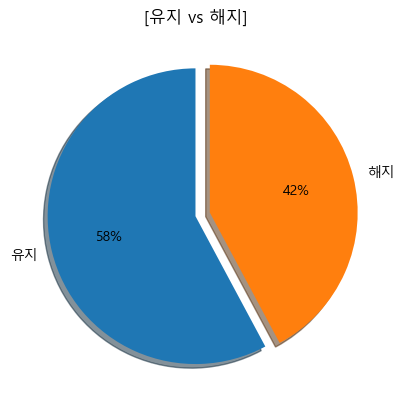

In [53]:
train_data['status'].value_counts()

# # 바-그래프로 확인하기
# train_data['status'].value_counts().plot(kind='bar')

# 파이-그래프로 확인하기
data = train_data['status'].value_counts() # chart를 그릴 데이터 생성하기
labels = ['유지','해지'] # chart에 들어갈 label 명칭 지정 안하면 'Y','N'이 됨

plt.pie(data, labels = labels, autopct='%.0f%%',
        shadow=True,explode=(0,0.1),startangle=90,)
plt.title("[유지 vs 해지]")
plt.show()


## 2-2.수치형 데이터 분석하기

In [54]:
import math 

# 전처리 후에 변경이 있으므로 수치형 칼럼을 모은 num_cols 리스트를 다시 생성하기
numbers=['int64','float64']
num_cols = train_data.select_dtypes(numbers).columns

# 모든 수치형 칼럼에 대해 히스토그램을 그리는 함수
def make_histplot(df,num_cols,label):    
    col_cnt=4
    graph_size=5
    num=len(num_cols)
    print("대상 칼럼수:", num)
    
    # 그려야 할 전체 그래프의 크기를 정하기 
    plt.rcParams['figure.figsize']=(col_cnt*graph_size, math.ceil(num/col_cnt)*graph_size)
    
    # 그려야 할 각각의 그래프의 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt,nrows=math.ceil(num/col_cnt)) 
    i=0 
    for column in tqdm(num_cols):
        df[column].hist(ax=ax[int(i/col_cnt)][i%col_cnt]) # 도수분포표(histogrma) 그리기
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']') # 칼럼명을 제목으로 붙이기   
        i=i+1

    plt.show()
    plt.rcParams['figure.figsize']=(7,7) # figsize를 원복

대상 칼럼수: 22


100%|██████████| 22/22 [00:00<00:00, 162.96it/s]


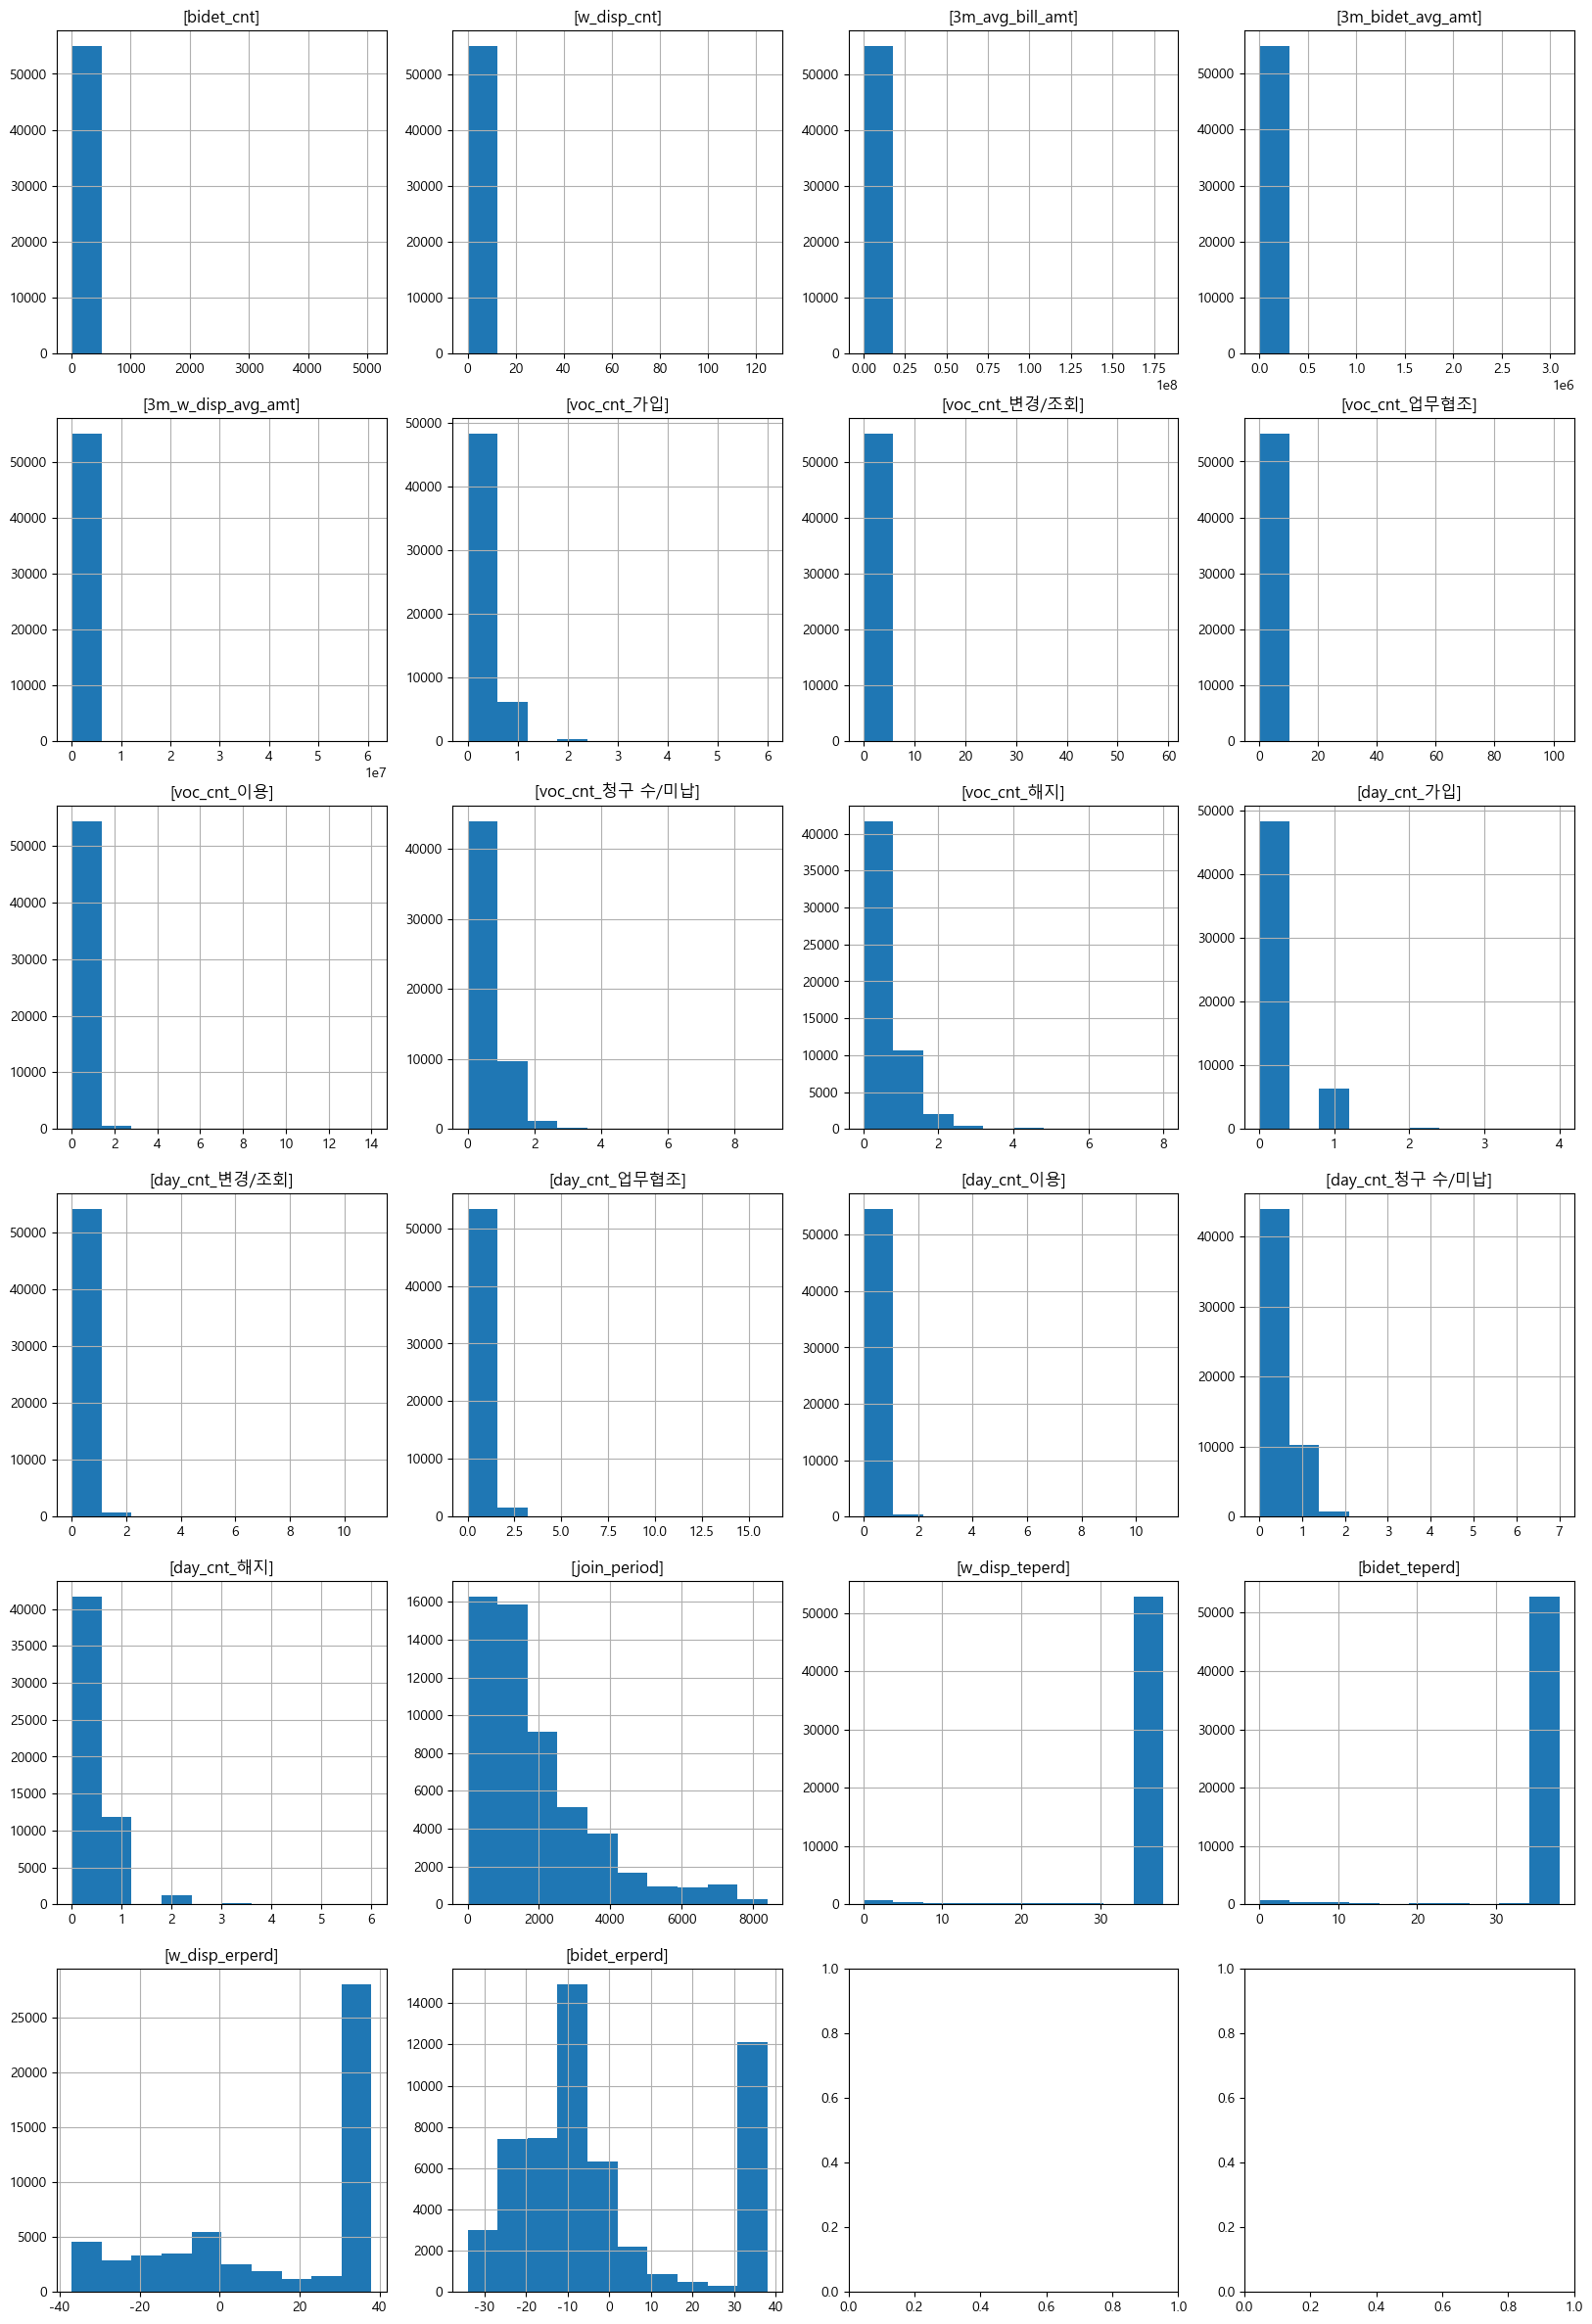

In [55]:
# 함수 실행하기
make_histplot(train_data,num_cols,'status')

## 2-3. 수치형 데이터의 이상치 제거하기

### 1)이상치 제거 대상 선별
- 최댓값을 기준으로 이상치 제거 대상 칼럼을 선별한다
- 여기서는 최댓값이 20보다 큰 칼럼을 이상치 제거 칼럼으로 선정한다.

In [56]:
# 각 칼럼별 max값 확인하기
train_data.describe().loc['max']

bidet_cnt            5.077000e+03
w_disp_cnt           1.250000e+02
3m_avg_bill_amt      1.806220e+08
3m_bidet_avg_amt     3.092769e+06
3m_w_disp_avg_amt    6.078027e+07
voc_cnt_가입           6.000000e+00
voc_cnt_변경/조회        5.900000e+01
voc_cnt_업무협조         1.020000e+02
voc_cnt_이용           1.400000e+01
voc_cnt_청구 수/미납      9.000000e+00
voc_cnt_해지           8.000000e+00
day_cnt_가입           4.000000e+00
day_cnt_변경/조회        1.100000e+01
day_cnt_업무협조         1.600000e+01
day_cnt_이용           1.100000e+01
day_cnt_청구 수/미납      7.000000e+00
day_cnt_해지           6.000000e+00
join_period          8.396000e+03
w_disp_teperd        3.800000e+01
bidet_teperd         3.800000e+01
w_disp_erperd        3.800000e+01
bidet_erperd         3.800000e+01
Name: max, dtype: float64

In [57]:
# max값이 20초과인 칼럼을 리스트로 만들기
outlier_cols=train_data.describe().loc['max'][train_data.describe().loc['max']>20].index.tolist()
outlier_cols

['bidet_cnt',
 'w_disp_cnt',
 '3m_avg_bill_amt',
 '3m_bidet_avg_amt',
 '3m_w_disp_avg_amt',
 'voc_cnt_변경/조회',
 'voc_cnt_업무협조',
 'join_period',
 'w_disp_teperd',
 'bidet_teperd',
 'w_disp_erperd',
 'bidet_erperd']

### 2)이상치 제거하기

In [58]:
# 이상치 기준이 되는 upperfence와 lowerfence지점의 위치 값을 계산하고 반환하기
def outliers_iqr(df,column,uorl,upper=75,lower=25,factor=1.5):
    q1,q3 = np.percentile(df[column],[lower,upper]) # 1분위 수, 3분위 수 구하기
    iqr=q3-q1
    if uorl=='l': # l이면 하한, u이면 상한
        return (q1-(iqr*factor))
    elif uorl=='u':
        return (q3+(iqr*factor))   
    
    
# 이상치(upperfence 초과)를 upperfence로 대체하는 함수, lower는 고려하지 않음
def replace_outlier(df,cols,upper=75,lower=25,factor=1.5):
    for column in cols:
        upperfence=outliers_iqr(df,column,'u',upper,lower,factor)
        df[column]=df[column].apply(lambda x: x if x <=upperfence else upperfence)        
        

In [59]:
# 시각화를 위한 데이터는 따로 복제하여 이상치를 제거하여 사용하기
train_data_del_outlier=train_data.copy()

replace_outlier(train_data_del_outlier,outlier_cols,factor=1.5)

## 2-4. 이상치 제거 후 수치형 데이터 분석하기

### 1)히스토그램(histogram)
- 값이 어떻게 분포하는가?
- 계급 구간별 건수 파악 용이

대상 칼럼수: 22


100%|██████████| 22/22 [00:00<00:00, 209.19it/s]


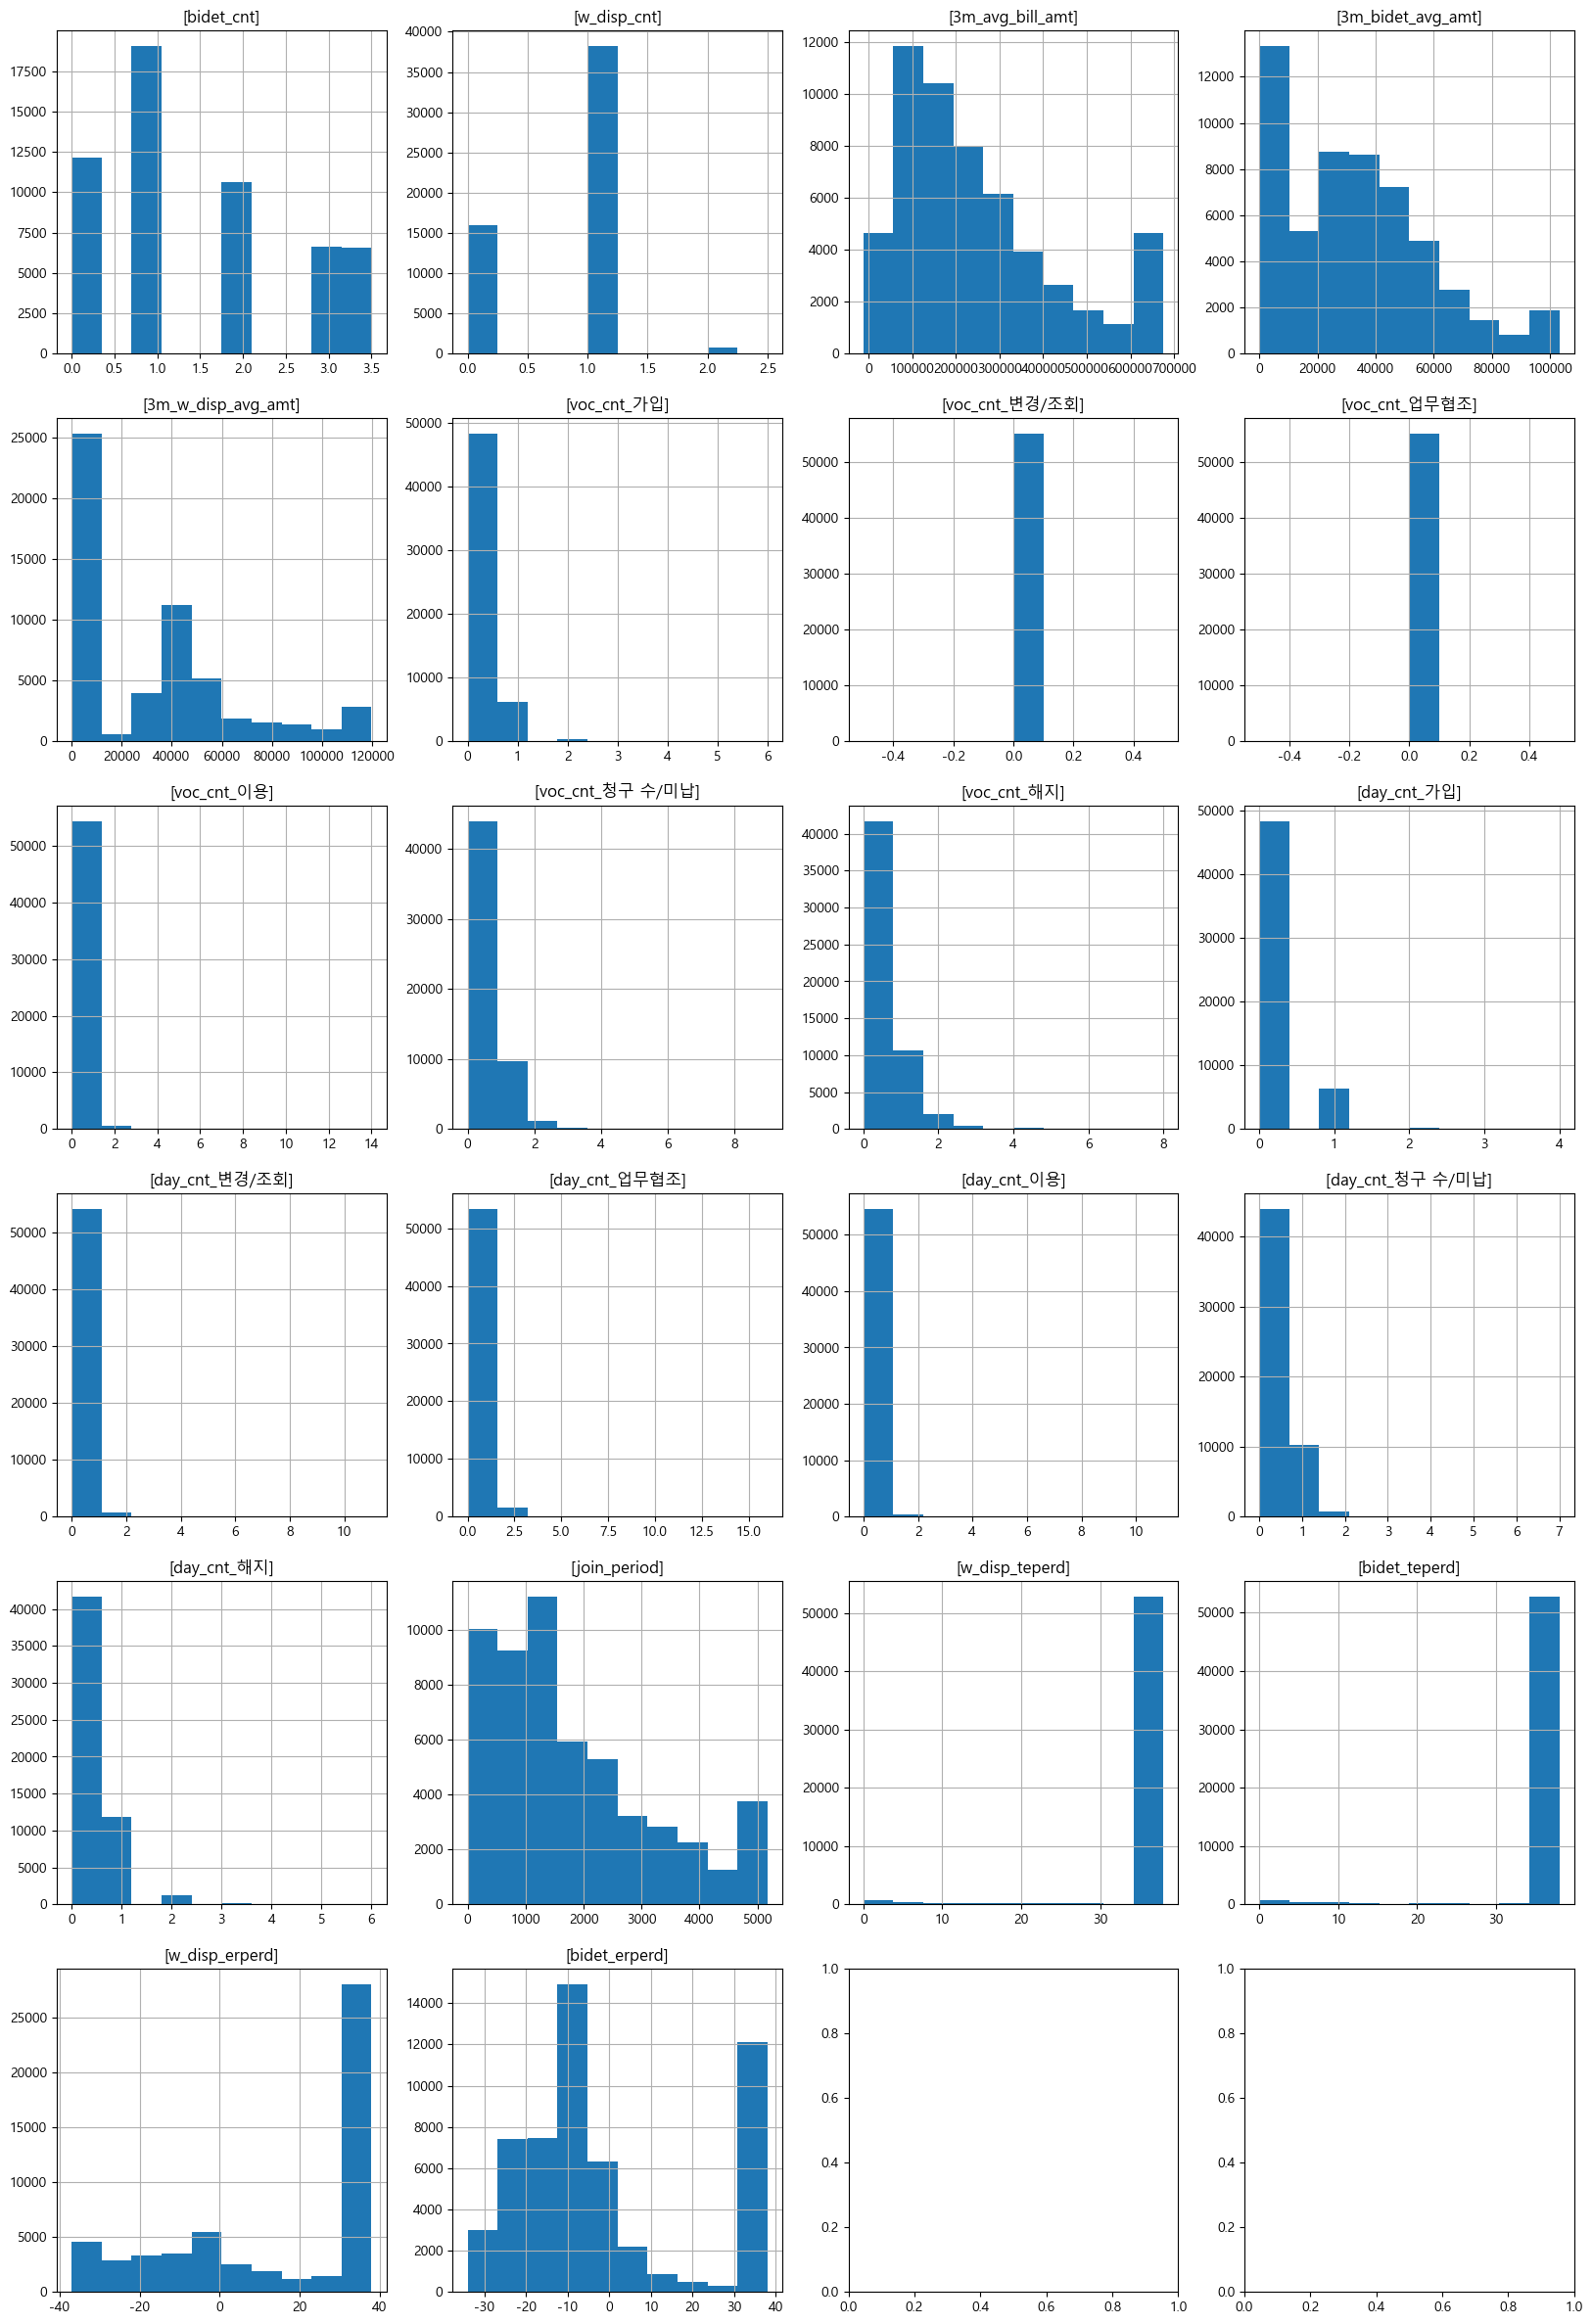

In [60]:
# 앞서 만든 함수로 수치형 칼럼에 대해 히스토그램 그리기
make_histplot(train_data_del_outlier,num_cols,'status')

### 2)커널밀도추정그래프(kdeplot)
- 히스토그램의 단점 보완
- 구간을 나눠서 표현하기 보다 데이터의 밀도 분포를 추정하여 곡선으로 보여줌
- 그래프를 겹쳐 그릴 수 있어 항목 간 비교하기 좋음
- 추정을 기반으로 하기 때문에 실제로 존제하지 않은 데이터를 그림

In [61]:
# 수치형 칼럼에 대해서 커널밀도추정그래프(kdeplot)을 그리는 함수
def make_kdeplot(df,num_cols,label):
    num=len(num_cols)
    col_cnt=4
    graph_size=5
    print("대상 칼럼수:", num)
    
    # 그려야할 전체 그래프의 크기를 정하기
    plt.rcParams['figure.figsize']=(col_cnt*graph_size,math.ceil(num/col_cnt)*graph_size) 
    
    # 그려야할 각각의 그래프의 위치 정하기 
    fig, ax = plt.subplots(ncols=col_cnt,nrows=math.ceil(num/col_cnt)) 
    i=0         
    for column in tqdm(num_cols):
        sns.kdeplot(data=df,x=column,hue=label,ax=ax[int(i/col_cnt)][i%col_cnt]) 
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']') #칼럼명을 제목으로 붙이기
        ax[int(i/col_cnt)][i%col_cnt].set_xlabel('') #x축의 이름을 공란으로 표기하기
        i=i+1

    plt.show()
    plt.rcParams['figure.figsize']=(7,7)

대상 칼럼수: 22


100%|██████████| 22/22 [00:04<00:00,  5.06it/s]


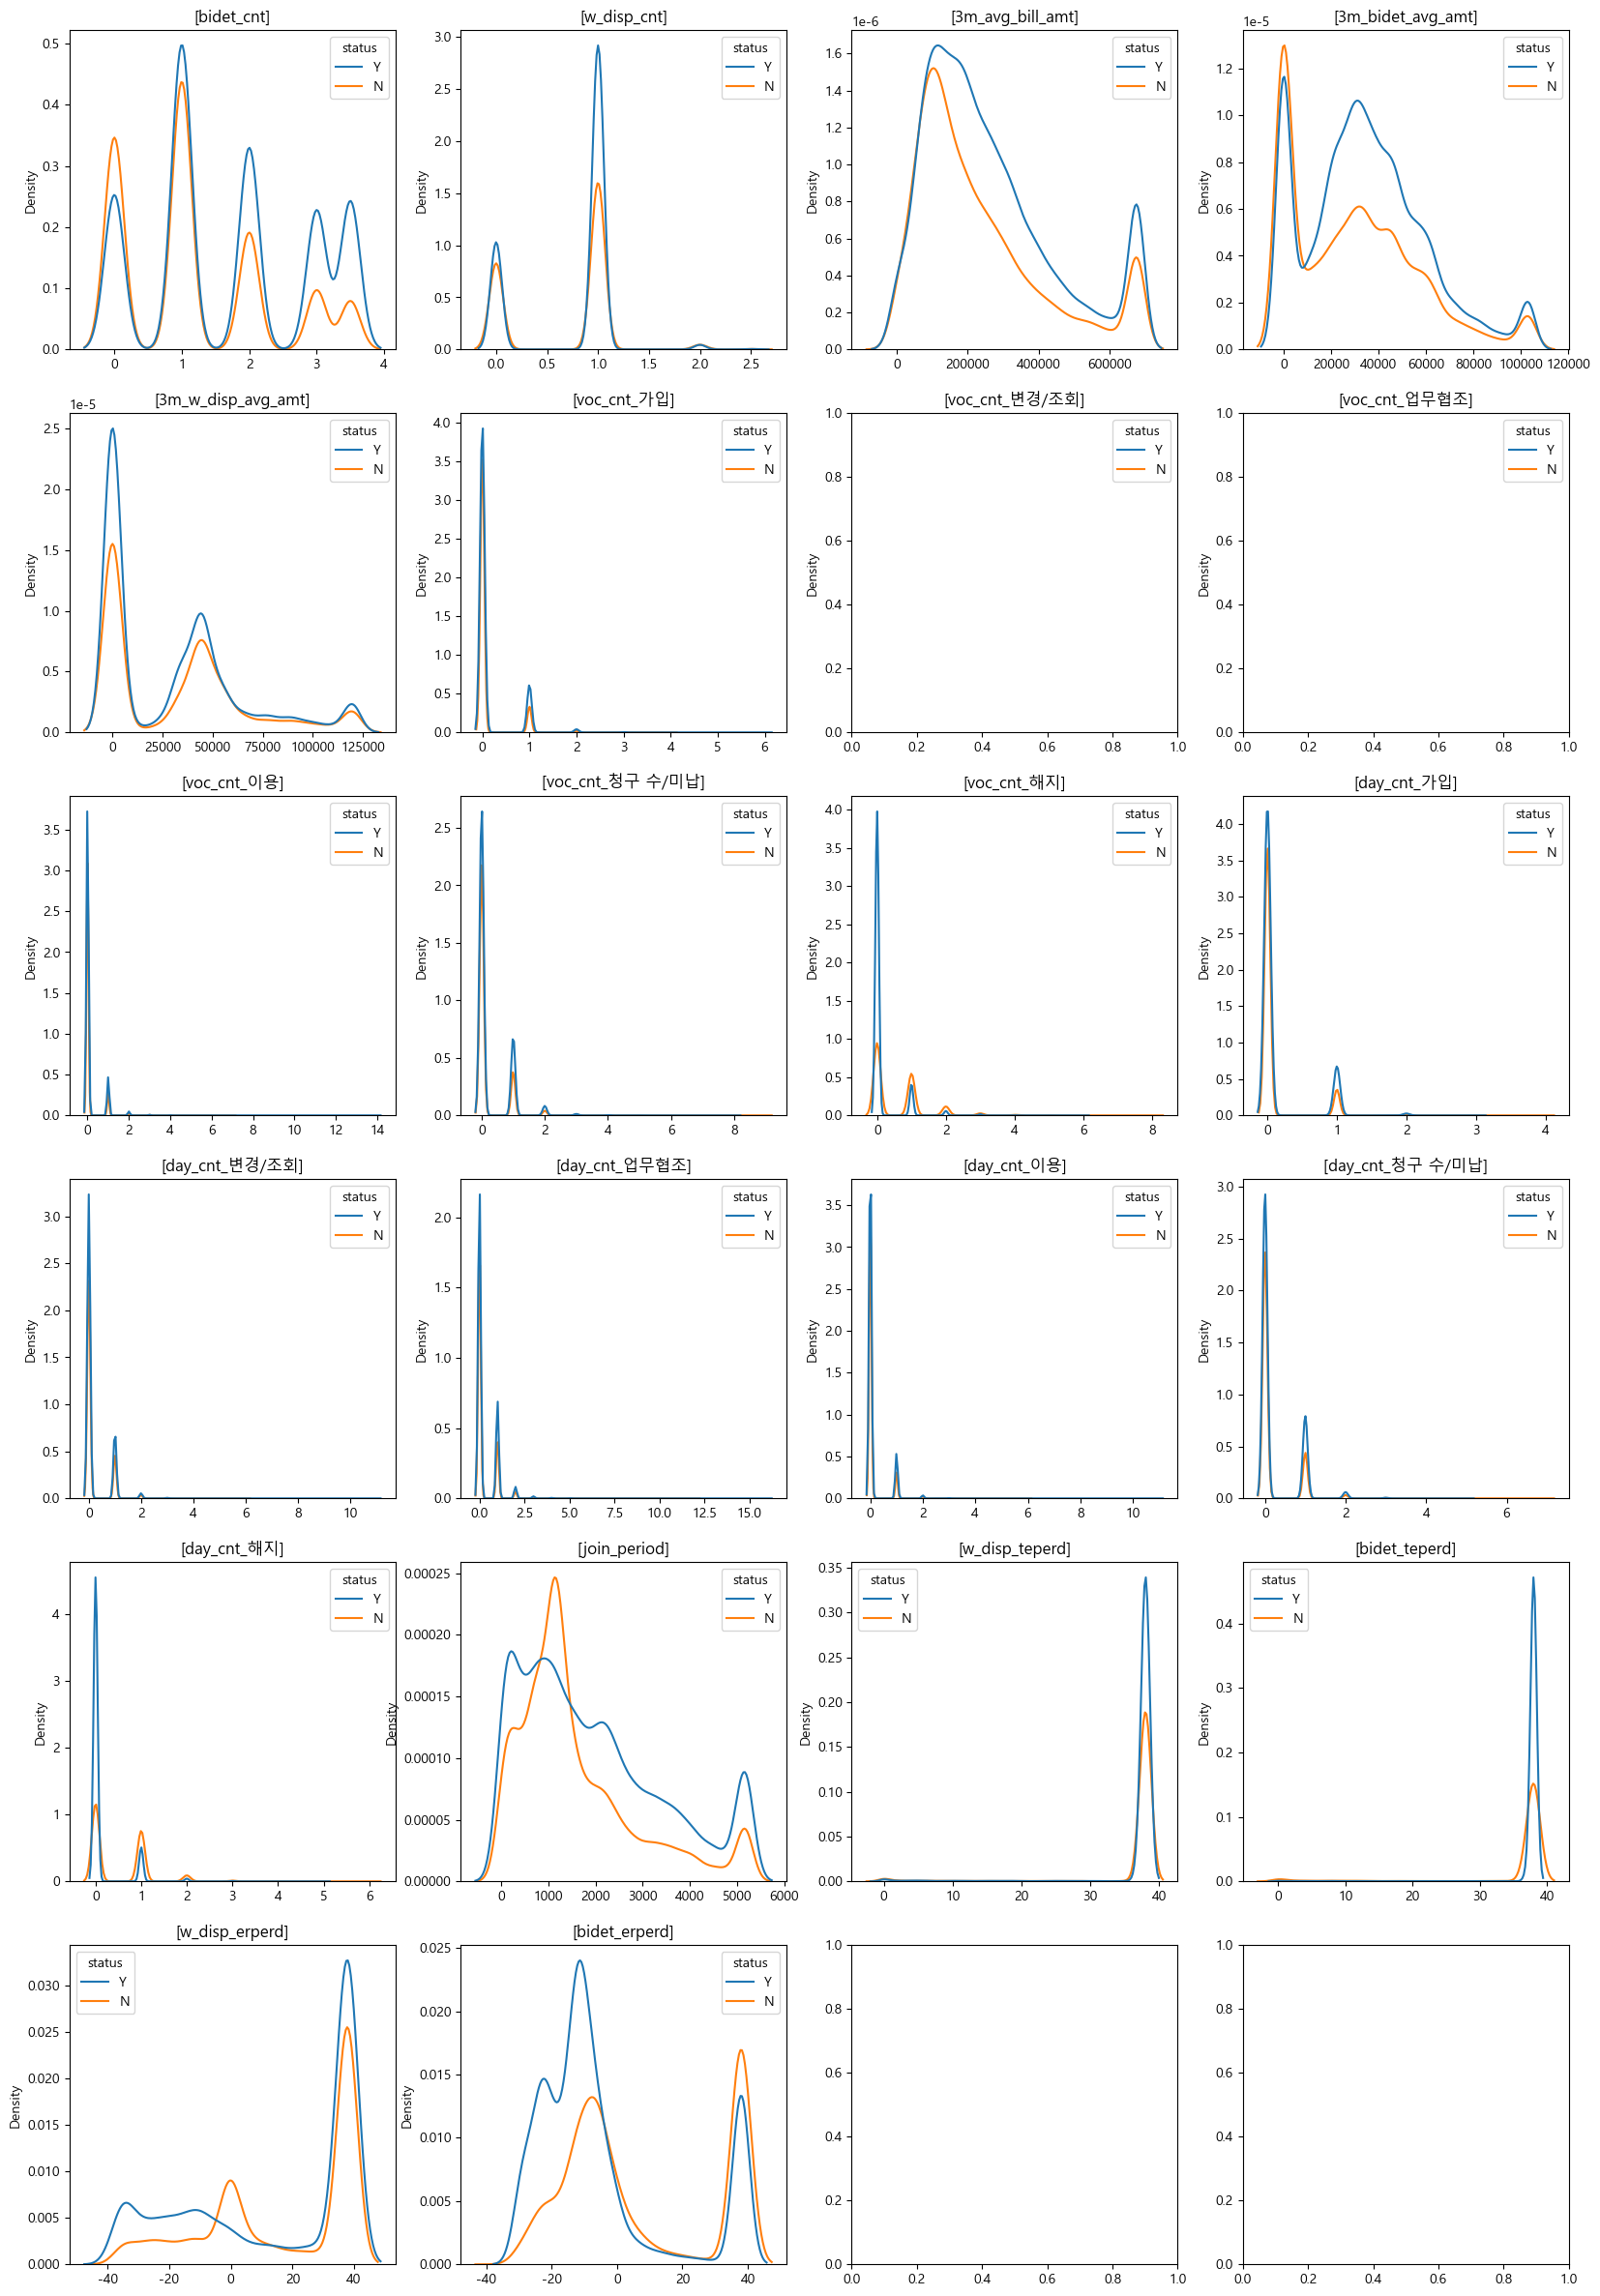

In [62]:
# 앞서 만든 함수로 수치형 칼럼에 대해 커널밀도추정그래프(kdeplot) 그리기
make_kdeplot(train_data_del_outlier,num_cols,'status')

In [63]:
#--> join_period : 1100일 정도에서 해지가 급격히 증가함. 3년 약정이 끝나면서 해지함. 재약정 유도에 해지를 방어해야 함.
#--> voc_cnt_해지, day_cnt_해지 : VOC가 1 이상일 때, 유지 건수 > 해지 건수, VOC가 증가하면 해지가 늘어남
#--> w_disp_erperd : 약정 만료(0)되는 시점에서 해지를 많이함
#--> bidet_erperd : 초기에 해지를 많이 함(-40 ~ -20) --> 고객 설문을 통해 만족도 및 해지사유를 추가로 확인할 필요가 있음

### 3)포인트그래프(pointplot)
- Y축 : 주어진 값의 평균값
- 값의 분포에 따라 왜곡이 있을 수 있지만, 서로 다른 범주의 데이터를 비교하기 좋다

In [64]:
# 수치형 칼럼에 대해서 포인트그래프를 그리는 함수 생성하기
def make_pointplot(df,num_cols,label):       
    num=len(num_cols)
    col_cnt=4
    graph_size=5
    print("대상 칼럼수:", num)
    
    # 그려야할 전체 그래프의 크기 정하기
    plt.rcParams['figure.figsize']=(col_cnt*graph_size,math.ceil(num/col_cnt)*graph_size) 
    
    # 그려야할 각각의 그래프의 위치 정하기   
    fig, ax = plt.subplots(ncols=col_cnt,nrows=math.ceil(num/col_cnt)) 
    i=0          
    for column in tqdm(num_cols):
        sns.pointplot(data=df,y=column,x=label,ax=ax[int(i/col_cnt)][i%col_cnt])    
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']')  # 칼럼명을 제목으로 붙이기
        ax[int(i/col_cnt)][i%col_cnt].set_ylabel('')             # y축의 이름을 공란으로 하기
        i=i+1

    plt.show()
    plt.rcParams['figure.figsize']=(7,7)

대상 칼럼수: 22


100%|██████████| 22/22 [00:05<00:00,  4.17it/s]


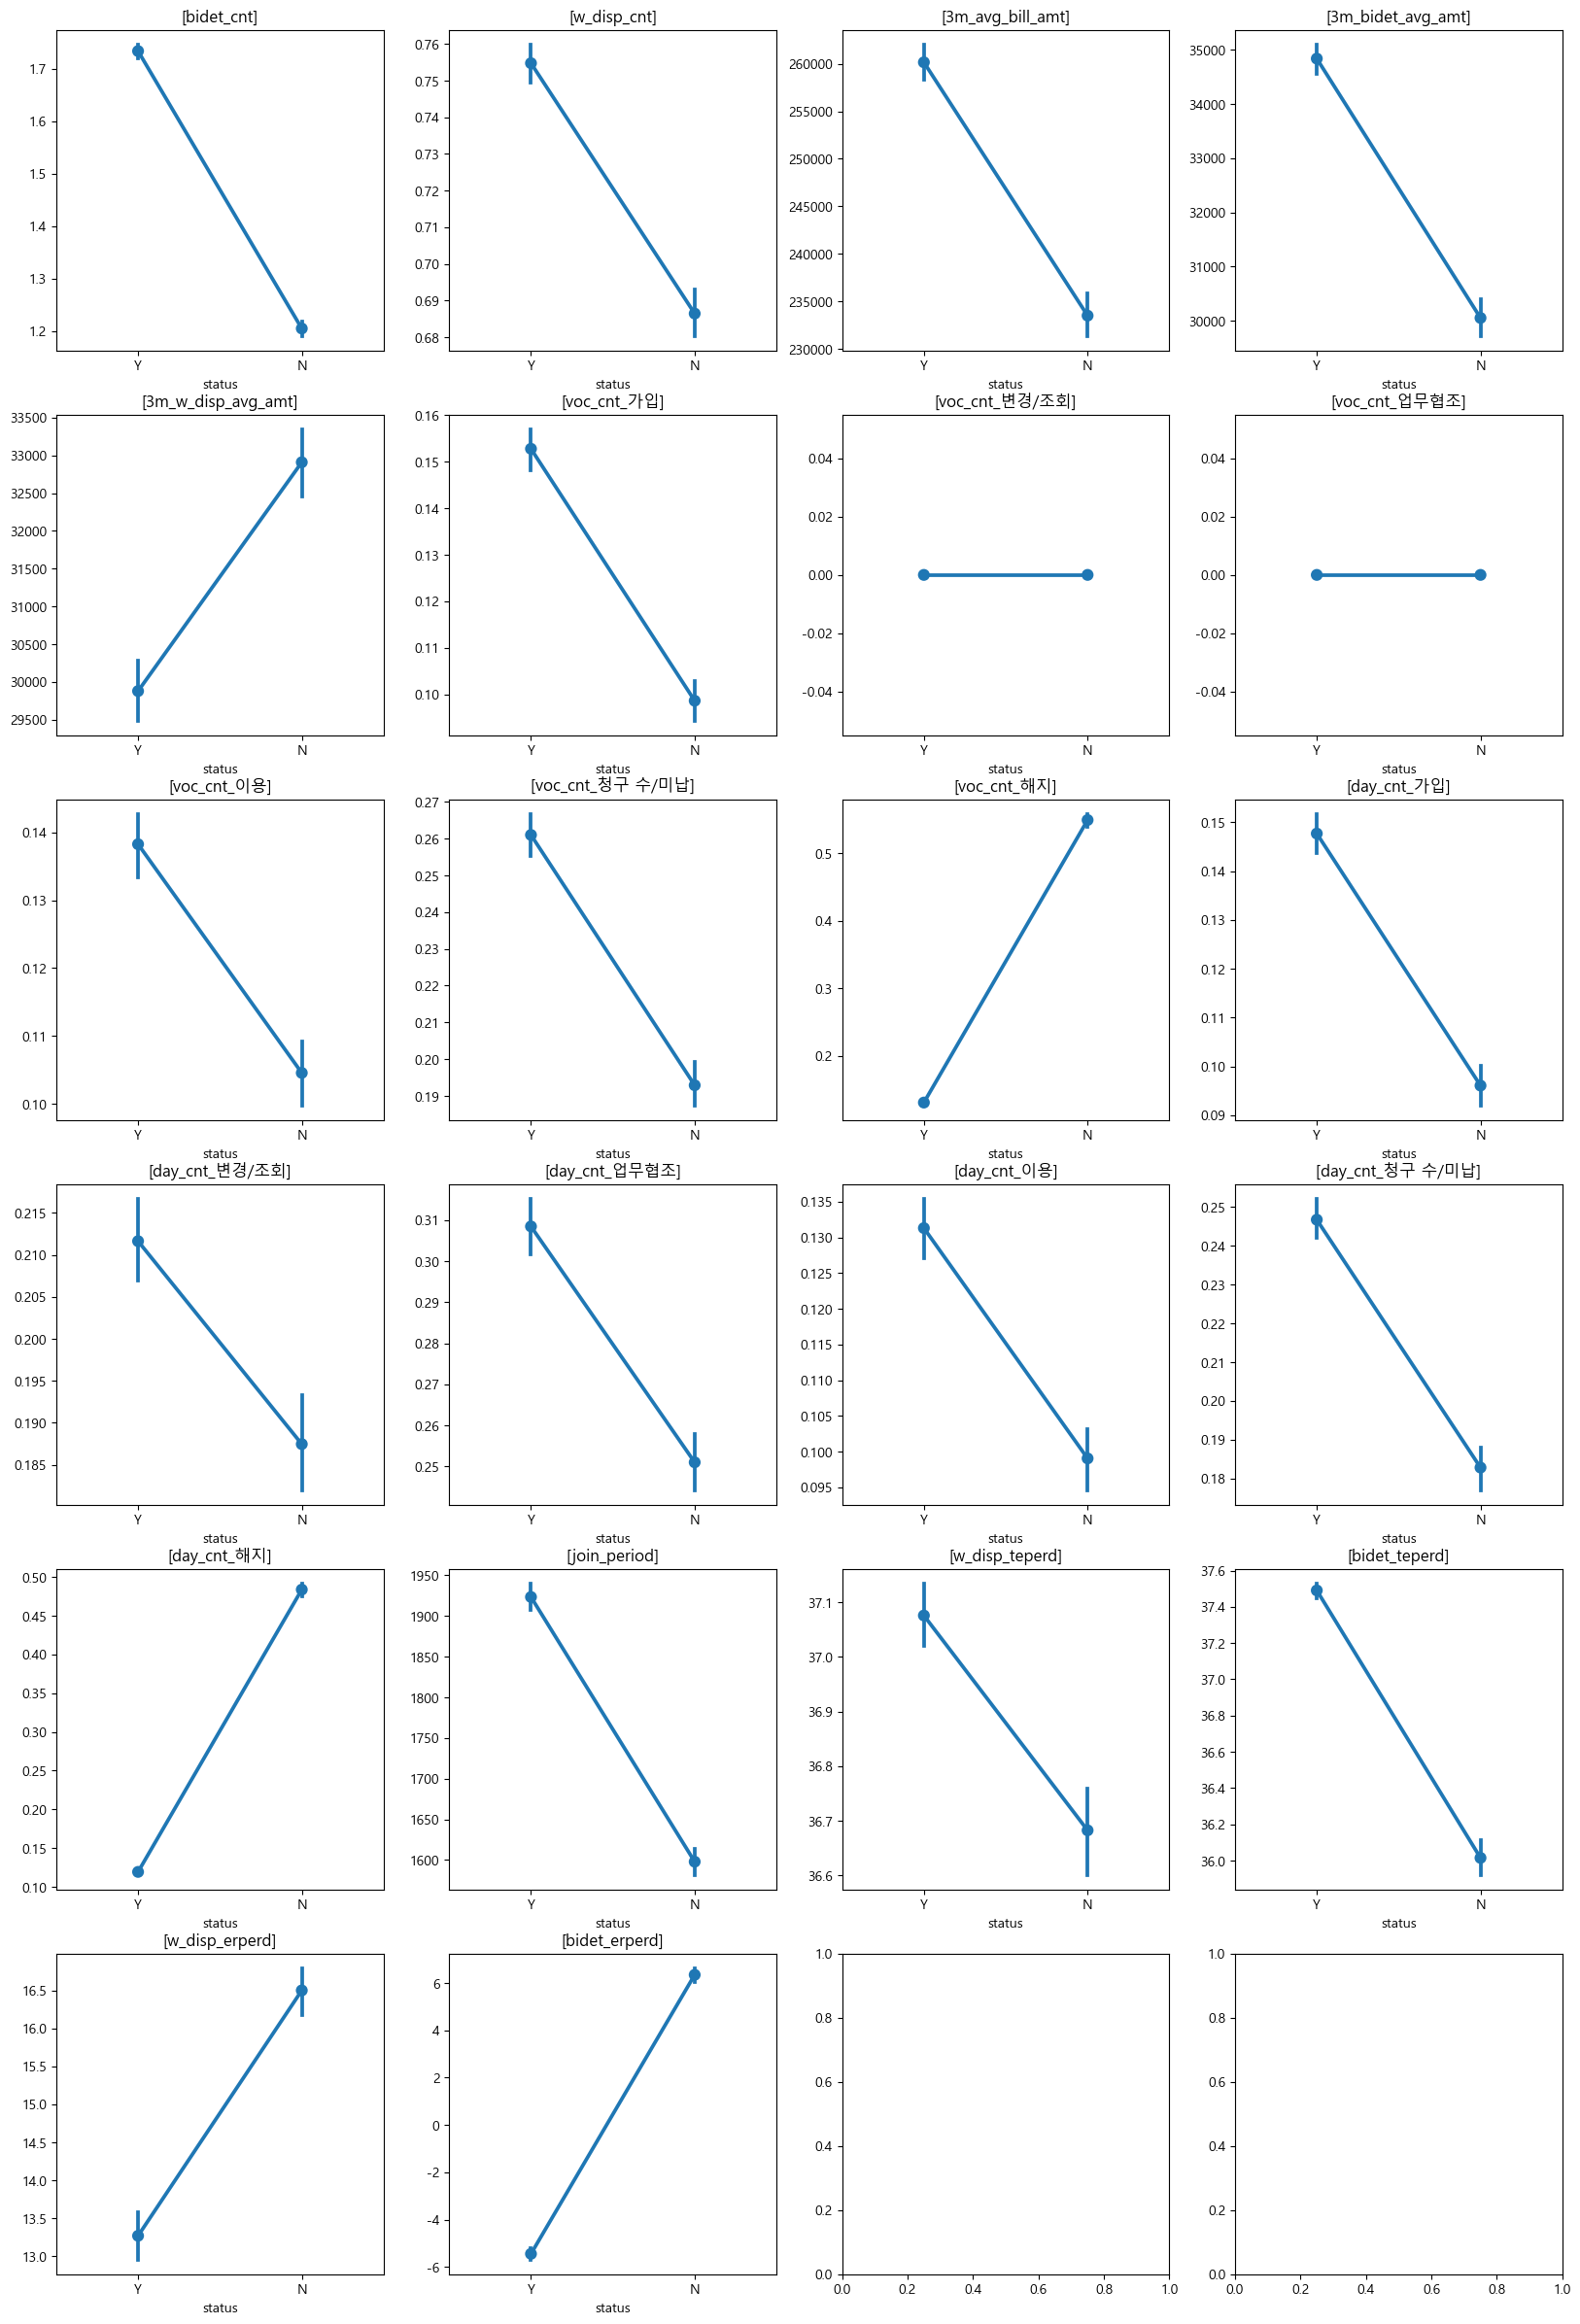

In [65]:
# 앞서 만든 함수로 수치형 칼럼에 대해 포인트그래프 그리기
make_pointplot(train_data_del_outlier,num_cols,'status')

## 2-5. 범주형 데이터 분석하기

### 1)빈도 그래프(countplot)

In [66]:
# 범주형 칼럼 리스트 생성하기
obj_cols = train_data.select_dtypes('O').columns
obj_cols

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

In [67]:
# 범주형 칼럼에 대해서 빈도그래프를 그리는 함수 생성하기
def make_countplot(df,obj_cols,label):    
    num=len(obj_cols)
    col_cnt=4
    graph_size=5
    print("대상 칼럼수:", num)
    
    # 그려야할 전체 그래프의 크기를 정하기 
    plt.rcParams['figure.figsize']=(col_cnt*graph_size,math.ceil(num/col_cnt)*graph_size) 
    
    # 그려야할 각각의 그래프의 위치 정하기
    fig, ax = plt.subplots(ncols=col_cnt,nrows=math.ceil(num/col_cnt)) 
    i=0    
    for column in obj_cols:
        sns.countplot(data=df,x=column,hue=label,ax=ax[int(i/col_cnt)][i%col_cnt])
        ax[int(i/col_cnt)][i%col_cnt].set_title('['+column+']') # 칼럼명을 제목으로 붙이기
        ax[int(i/col_cnt)][i%col_cnt].set_xlabel('')            # x축의 이름을 공란으로 처리하기
        i=i+1
    plt.show()
    plt.rcParams['figure.figsize']=(7,7)

대상 칼럼수: 8


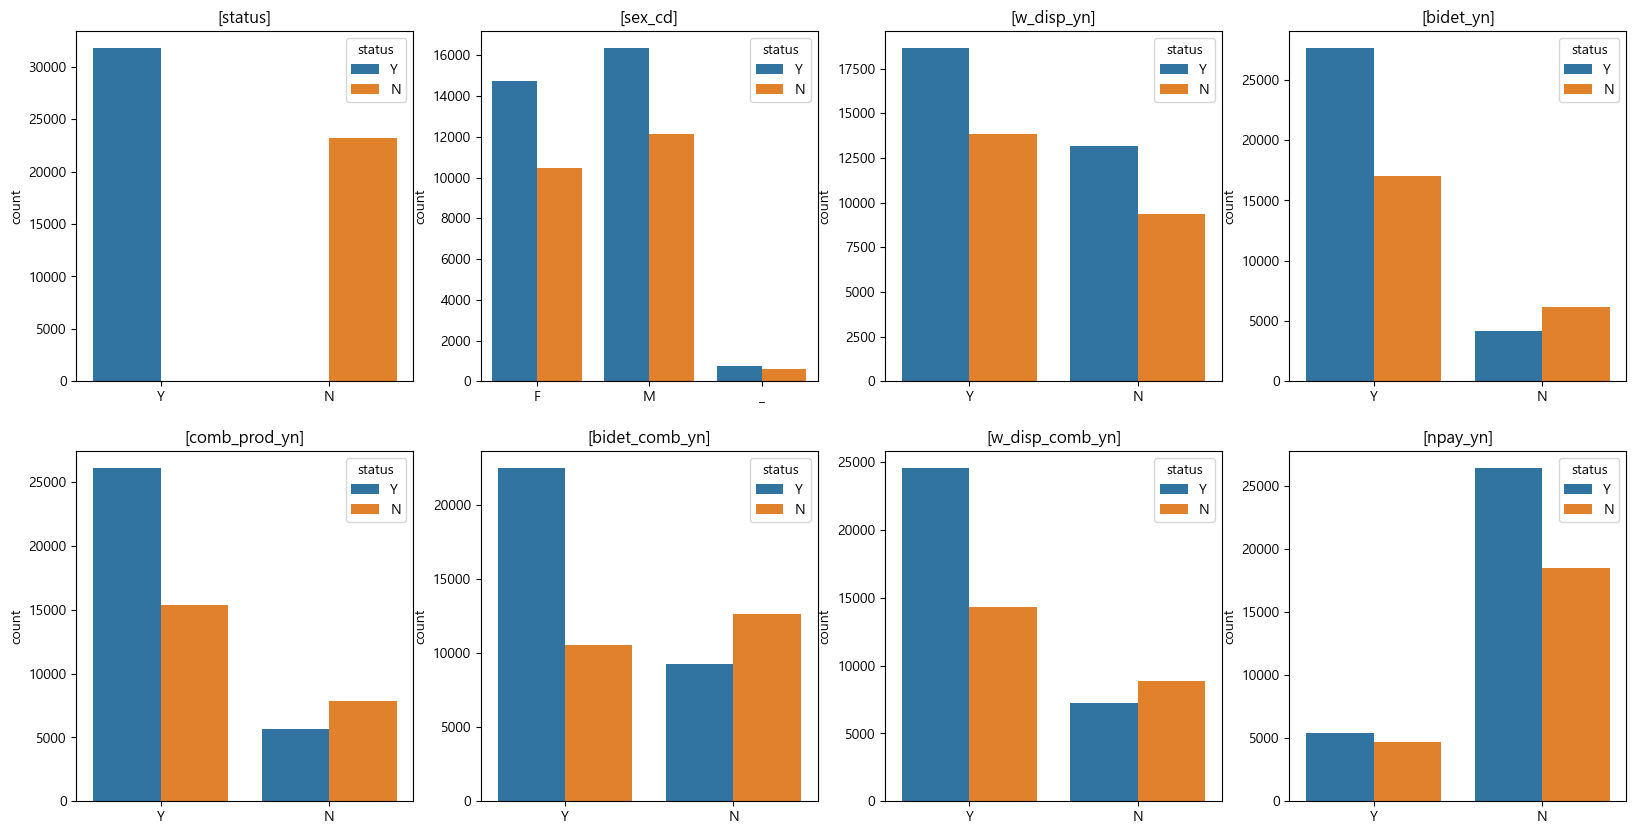

In [68]:
make_countplot(train_data,obj_cols,'status')

In [69]:
# --> bidet_yn : 비데를 가입하지 않은(Y) 고객이 해지 비율이 높음
# --> comb_prod_yn : 결합상품을 한 고객의 해지 비율이 높음
# --> bidet_comb_yn : 비데를 결합하지 않은(정수기만 한) 고객의 해지 비율이 높음
# --> w_disp_comb_yn : 정수기를 결합한 (비데 + 정수기) 고객의 해지비율이 높음

# --> 비데를 가입하면 해지를 덜 하는 경향이 있음

# 3.AI모델링을 위한 전처리(Preprocessing)하기

## 3-1. 표준화와 정규화하기
- 일반적으로 표준화 > 이상치 제거 > 정규화 순서로 진행한다
- 상황에 따라 순서가 바뀌거나 일부만 적용할 수 있다.
- EDA나 시각화는 이상치가 있으면 분석이 힘들기 때문에 별도 데이터프레임으로 복사하여 이상치를 제거한 후 사용했음
- 표준화, 정규화는 수치형 데이터에만 진행한다

In [70]:
# 수치형 칼럼 리스트를 만들기
numbers=['int64','float64']
num_cols = train_data.select_dtypes(numbers).columns
num_cols

Index(['bidet_cnt', 'w_disp_cnt', '3m_avg_bill_amt', '3m_bidet_avg_amt',
       '3m_w_disp_avg_amt', 'voc_cnt_가입', 'voc_cnt_변경/조회', 'voc_cnt_업무협조',
       'voc_cnt_이용', 'voc_cnt_청구 수/미납', 'voc_cnt_해지', 'day_cnt_가입',
       'day_cnt_변경/조회', 'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_청구 수/미납',
       'day_cnt_해지', 'join_period', 'w_disp_teperd', 'bidet_teperd',
       'w_disp_erperd', 'bidet_erperd'],
      dtype='object')

### 1)표준화(standardization = Z-score Nomalization)하기

In [71]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()

# 수치형 칼럼에 표준화 적용하기
train_data[num_cols] = standardScaler.fit_transform(train_data[num_cols])
test_data[num_cols]=standardScaler.transform(test_data[num_cols])

# 표준화 결과 확인하기
train_data[num_cols].describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04
mean,-2.712981e-18,-5.083610e-17,2.170385e-17,-2.842171e-18,-4.844610e-18,-1.446923e-17,7.893484e-17,3.035955e-18,3.501038e-17,-1.098112e-17,-6.188181e-17,-9.650462e-17,4.825231e-17,1.653627e-17,-4.805853e-17,7.880565e-18,-1.627789e-17,-7.137725e-17,-3.214237e-16,3.225864e-16,-1.227301e-17,5.167584e-19
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-3.906204e-02,-6.483763e-01,-3.565643e-01,-8.977446e-01,-1.049899e-01,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,-4.944116e-01,-3.616351e-01,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-1.149802e+00,-6.558596e+00,-6.458014e+00,-1.942736e+00,-1.496733e+00
25%,-2.401956e-02,-6.483763e-01,-2.134368e-01,-6.026667e-01,-1.049899e-01,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,-4.944116e-01,-3.616351e-01,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-6.869425e-01,1.936772e-01,1.982746e-01,-8.891769e-01,-6.484492e-01
50%,-2.401956e-02,2.310707e-01,-1.084393e-01,-8.702069e-02,-2.262107e-02,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,-4.944116e-01,-3.616351e-01,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-3.100954e-01,1.936772e-01,1.982746e-01,7.287895e-01,-3.359236e-01
75%,-8.977078e-03,2.310707e-01,5.265599e-02,3.555961e-01,1.585976e-02,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,-4.944116e-01,-3.616351e-01,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,4.077088e-01,1.936772e-01,1.982746e-01,8.792980e-01,4.677136e-01
max,7.633160e+01,1.092825e+02,2.122352e+02,7.978902e+01,1.531834e+02,1.603414e+01,1.063694e+02,1.147525e+02,3.478769e+01,1.718309e+01,1.238241e+01,1.112713e+01,2.410769e+01,2.708659e+01,3.000389e+01,1.458585e+01,1.104128e+01,4.045614e+00,1.936772e-01,1.982746e-01,8.792980e-01,1.717816e+00


### 2)정규화(Normalization)하기

In [72]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()

# 수치형 칼럼에 정규화 적용하기
train_data[num_cols] = minMaxScaler.fit_transform(train_data[num_cols])
test_data[num_cols]=minMaxScaler.transform(test_data[num_cols])

# 정규화 결과 확인하기
train_data[num_cols].describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
count,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,0.000511,0.005898,0.001677,0.011126,0.000685,0.021655,0.003639,0.003259,0.008861,0.025808,0.038395,0.031477,0.018312,0.017764,0.010699,0.031395,0.045485,0.221311,0.971317,0.970212,0.688417,0.465612
std,0.013094,0.009097,0.004704,0.012394,0.006524,0.061017,0.009367,0.008686,0.028491,0.056695,0.077660,0.087042,0.040721,0.036263,0.032973,0.066408,0.086450,0.192479,0.148100,0.150235,0.354358,0.311088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000197,0.000000,0.000673,0.003657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089090,1.000000,1.000000,0.373333,0.263889
50%,0.000197,0.008000,0.001167,0.010048,0.000537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161625,1.000000,1.000000,0.946667,0.361111
75%,0.000394,0.008000,0.001925,0.015533,0.000788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.299786,1.000000,1.000000,1.000000,0.611111
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3-2.레이블 인코딩(Lable Encoding)하기
- 범주형 데이터를 정수로 바꿈
- 원핫인코딩과 비슷해 보이지만 다름

In [73]:
# 레이블 인코딩 대상 칼럼 찾기
le_columns= train_data.select_dtypes('O').columns
le_columns

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

In [74]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 객체로 생성한 후 , fit( ) 과 transform( ) 으로 label 인코딩 수행하기
le = LabelEncoder()

for column in le_columns:
    
    le.fit(train_data[column])
    
    train_data[column]=le.transform(train_data[column])
    
    # train_data에 없는 label이 test_data에 있을 수 있으므로 아래 코드가 필요하며, test_data는 fit 없이 transform만 해야함
    for label in np.unique(test_data[column]):
        
        if label not in le.classes_: # unseen label 데이터인 경우( )
            le.classes_ = np.append(le.classes_, label) # 미처리 시 ValueError발생
            print(le.classes_)
            
    test_data[column]=le.transform(test_data[column])        


In [75]:
# 변환 값 확인하기:  N이 0, Y가 1로 변경됨
le.classes_

array(['N', 'Y'], dtype=object)

In [76]:
train_data.head()

,status,bidet_cnt,w_disp_cnt,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,1,0.000197,0.000,0,1,1,1,1,1,1,0.002176,0.013060,0.000717,0.0,0.0,0.000000,0.0,0.111111,0.000,0.0,0.0,0.0000,0.0,0.142857,0.000000,0.146260,1.0,1.0,0.373333,0.305556
1,0,0.000394,0.000,1,0,1,0,0,0,0,0.000672,0.011142,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.293354,1.0,1.0,1.000000,0.388889
2,0,0.000197,0.008,1,1,0,1,1,1,0,0.000561,0.000000,0.000471,0.0,0.0,0.009804,0.0,0.000000,0.000,0.0,0.0,0.0625,0.0,0.000000,0.000000,0.134231,1.0,1.0,0.493333,1.000000
3,1,0.000788,0.008,0,1,1,1,1,1,1,0.001271,0.011235,0.000905,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.474988,1.0,1.0,0.973333,0.319444
4,0,0.000197,0.008,0,1,1,1,1,1,0,0.001780,0.019354,0.000890,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.207837,1.0,1.0,0.133333,0.166667


In [77]:
# 유지를 예측하는 것이 아니라 해지를 예측해야 하므로 값을 반전시키기(0 >1 , 1> 0)
train_data['status']=train_data['status'].apply(lambda x:1 if x==0 else 0)
test_data['status']=test_data['status'].apply(lambda x:1 if x==0 else 0)

In [78]:
train_data.head()

,status,bidet_cnt,w_disp_cnt,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd
0,0,0.000197,0.000,0,1,1,1,1,1,1,0.002176,0.013060,0.000717,0.0,0.0,0.000000,0.0,0.111111,0.000,0.0,0.0,0.0000,0.0,0.142857,0.000000,0.146260,1.0,1.0,0.373333,0.305556
1,1,0.000394,0.000,1,0,1,0,0,0,0,0.000672,0.011142,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.293354,1.0,1.0,1.000000,0.388889
2,1,0.000197,0.008,1,1,0,1,1,1,0,0.000561,0.000000,0.000471,0.0,0.0,0.009804,0.0,0.000000,0.000,0.0,0.0,0.0625,0.0,0.000000,0.000000,0.134231,1.0,1.0,0.493333,1.000000
3,0,0.000788,0.008,0,1,1,1,1,1,1,0.001271,0.011235,0.000905,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.474988,1.0,1.0,0.973333,0.319444
4,1,0.000197,0.008,0,1,1,1,1,1,0,0.001780,0.019354,0.000890,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.207837,1.0,1.0,0.133333,0.166667


## 3-3. 원핫 인코딩(One Hot Encoding)하기

In [79]:
# 레이블 인코딩한 칼럼에 대해 범주를 확인하기
for column in le_columns:
    print(train_data[column].value_counts())

0    31806
1    23194
Name: status, dtype: int64
1    28486
0    25178
2     1336
Name: sex_cd, dtype: int64
1    32474
0    22526
Name: w_disp_yn, dtype: int64
1    44657
0    10343
Name: bidet_yn, dtype: int64
1    41462
0    13538
Name: comb_prod_yn, dtype: int64
1    33075
0    21925
Name: bidet_comb_yn, dtype: int64
1    38924
0    16076
Name: w_disp_comb_yn, dtype: int64
0    44920
1    10080
Name: npay_yn, dtype: int64


In [80]:
# 원핫 인코딩 대상 칼럼 지정하기
oh_columns=['sex_cd']

# 원핫 인코딩을 위한 패키지 불러오기
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoder를 객체로 생성한 후, fit( ) 과 transform( ) 으로 원핫 인코딩 수행하기 
enc = OneHotEncoder(sparse=False,drop='if_binary')
train_onehot=enc.fit_transform(train_data[oh_columns])
test_onehot=enc.transform(test_data[oh_columns])

train_onehot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [81]:
# pd.concat함수를 이용하여 train_data에 원핫 인코딩한 데이터를 붙여주고, 기존 칼럼은 삭제하기
train_data_OH=pd.concat([train_data,pd.DataFrame(train_onehot,columns=enc.get_feature_names_out(oh_columns))],axis=1)
test_data_OH=pd.concat([test_data,pd.DataFrame(test_onehot,columns=enc.get_feature_names_out(oh_columns))],axis=1)

# 만약, sklearn 버젼이 차이로 get_feature_names 에러 발생시 : 위의 코드는 주석처리하고 아래 2줄 주석 해제하고 수행
# train_data_OH=pd.concat([train_data,pd.DataFrame(train_onehot,columns=enc.get_feature_names_out(oh_columns))],axis=1)
# test_data_OH=pd.concat([test_data,pd.DataFrame(test_onehot,columns=enc.get_feature_names_out(oh_columns))],axis=1)

train_data_OH.drop(oh_columns,axis=1,inplace=True)
test_data_OH.drop(oh_columns,axis=1,inplace=True)

train_data=train_data_OH
test_data=test_data_OH

train_data

,status,bidet_cnt,w_disp_cnt,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,voc_cnt_해지,day_cnt_가입,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,w_disp_teperd,bidet_teperd,w_disp_erperd,bidet_erperd,sex_cd_0,sex_cd_1,sex_cd_2
0,0,0.000197,0.000,1,1,1,1,1,1,0.002176,0.013060,0.000717,0.0,0.0,0.000000,0.0,0.111111,0.000,0.0,0.0,0.0000,0.0,0.142857,0.000000,0.146260,1.0,1.000000,0.373333,0.305556,1.0,0.0,0.0
1,1,0.000394,0.000,0,1,0,0,0,0,0.000672,0.011142,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.293354,1.0,1.000000,1.000000,0.388889,0.0,1.0,0.0
2,1,0.000197,0.008,1,0,1,1,1,0,0.000561,0.000000,0.000471,0.0,0.0,0.009804,0.0,0.000000,0.000,0.0,0.0,0.0625,0.0,0.000000,0.000000,0.134231,1.0,1.000000,0.493333,1.000000,0.0,1.0,0.0
3,0,0.000788,0.008,1,1,1,1,1,1,0.001271,0.011235,0.000905,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.474988,1.0,1.000000,0.973333,0.319444,1.0,0.0,0.0
4,1,0.000197,0.008,1,1,1,1,1,0,0.001780,0.019354,0.000890,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.207837,1.0,1.000000,0.133333,0.166667,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,1,0.000000,0.008,1,0,1,0,1,1,0.000771,0.000000,0.000737,0.0,0.0,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.650667,1.0,1.000000,0.920000,1.000000,0.0,1.0,0.0
54996,0,0.000000,0.008,1,0,1,0,1,0,0.000611,0.000000,0.000796,0.0,0.0,0.000000,0.0,0.000000,0.125,0.0,0.0,0.0000,0.0,0.000000,0.166667,0.331467,1.0,0.973684,0.506667,1.000000,1.0,0.0,0.0
54997,0,0.000788,0.008,0,1,0,0,0,0,0.000494,0.004772,0.000000,0.0,0.0,0.019608,0.0,0.000000,0.000,0.0,0.0,0.0625,0.0,0.000000,0.000000,0.049905,1.0,1.000000,1.000000,0.222222,1.0,0.0,0.0
54998,0,0.000591,0.008,0,1,0,0,0,0,0.000695,0.004860,0.000000,0.0,0.0,0.000000,0.0,0.111111,0.125,0.0,0.0,0.0000,0.0,0.142857,0.166667,0.045855,1.0,1.000000,1.000000,0.208333,0.0,1.0,0.0


## 3-4. 다중공선성 제거하기

### 1)변수 간 상관관계 시각화와 상관계수 0.9이상 변수 확인하기

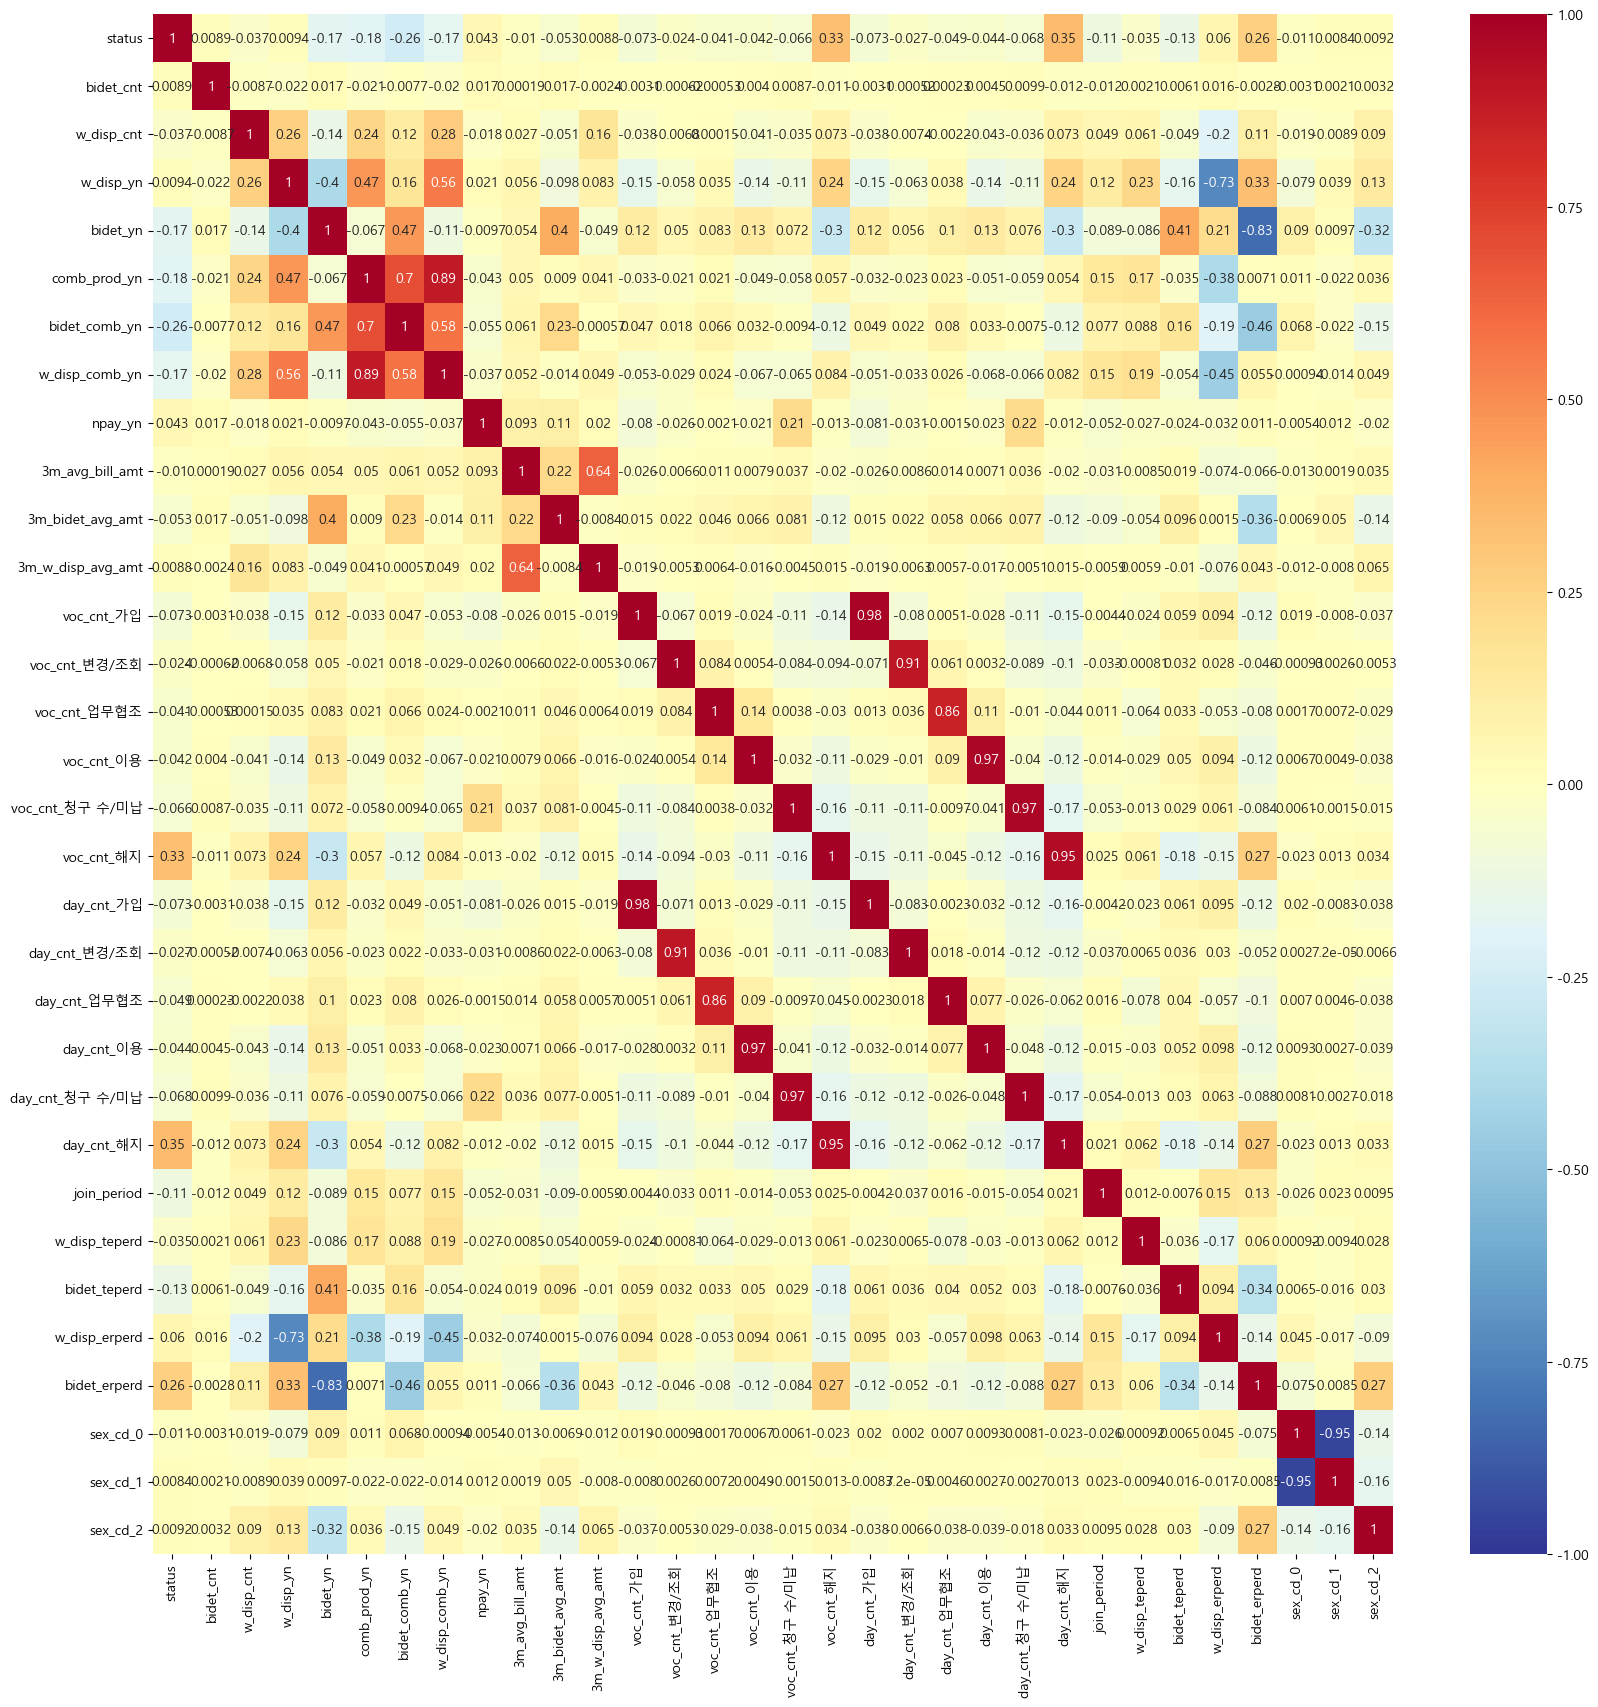

In [82]:
# 그래프 사이즈를 크게 설정하기
plt.rcParams["figure.figsize"]=(20,20)

# train_data의 상관관계를 히트맵 그리기
sns.heatmap(train_data.corr(),annot=True,cmap='RdYlBu_r',vmin=-1, vmax=1)

# 그래프 사이즈 원래대로 바꾸기
plt.rcParams["figure.figsize"]=(5,5)

In [83]:
check=[]
mcol_linearity=[]

train_corr=train_data.corr() #모든 변수의 상관관계 계산하기

# 행, 열 간의 상관관계를 계산하므로 for문 두 번 중첩해서 돌리기
for idx in train_corr.index:
    
    # 중복 계산에서 제외하기 위해 반복문을 수행할때 check 리스트에 넣기
    check.append(idx)
    for column in train_corr.columns:
        
        # train_corr가 대각선 방향으로 대칭이므로 두 번 계산을 피하기
        if column not in check:
            if (train_corr.loc[idx,column]>=0.9 and train_corr.loc[idx,column]<1) or (train_corr.loc[idx,column]<=-0.9 and train_corr.loc[idx,column]>-1):
                mcol_linearity.append([idx,column])        

mcol_linearity

[['voc_cnt_가입', 'day_cnt_가입'],
 ['voc_cnt_변경/조회', 'day_cnt_변경/조회'],
 ['voc_cnt_이용', 'day_cnt_이용'],
 ['voc_cnt_청구 수/미납', 'day_cnt_청구 수/미납'],
 ['voc_cnt_해지', 'day_cnt_해지'],
 ['sex_cd_0', 'sex_cd_1']]

In [84]:
upperNinety = (abs(train_data.corr()) >= 0.9) & (train_data.corr() != 1)

haveUpperNinety = train_data.corr()[upperNinety].isnull().sum() != 32

corrNinetyCols = train_data.corr()[upperNinety][haveUpperNinety].index

### 2)VIF(Variance Inflation Factor, 분산팽창계수) 확인하기
- 각 변수가 이상적인 회귀계수 대비 얼마나 팽창하는지(분산의 정도)를 나타내는 값이다.
- 각 독립 변수를 종속 변수, 나머지 독립변수를 독립변수로 설정하고 회귀분석을 수행해 산출된 결정계수를 기반으로 관계를 측정한다.

In [85]:
# VIF를 확인하기 위한 패키지 불러오기
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF계산 결과를 데이터프레임에 담기
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(train_data.values, i) for i in tqdm(range(train_data.shape[1]))]
vif['Feature'] = train_data.columns

# VIF값 순서대로 내림차순 정렬하기
vif = vif.sort_values(by="VIF_Factor", ascending=False).reset_index().drop(columns='index')
vif

100%|██████████| 32/32 [00:02<00:00, 13.45it/s]


,VIF_Factor,Feature
0,78.856820,sex_cd_1
1,69.817706,sex_cd_0
2,30.151701,day_cnt_가입
3,29.989551,voc_cnt_가입
4,19.843202,voc_cnt_이용
5,19.704720,day_cnt_이용
6,17.885240,day_cnt_청구 수/미납
7,17.683755,voc_cnt_청구 수/미납
8,10.156037,day_cnt_해지
9,9.917521,voc_cnt_해지


### 3)다중공선성이 발생하는 변수 선택 및 삭제하기
- 다중공선성이 발생한다고 해도 변수 하나을 무조건 버려야 하는 것은 아니다
- 두 변수가 서로 관련 있으나 개별적으로 종속 변수에 영향을 미치는 경우도 있기 때문이다.
- 일괄적으로 삭제하면 데이터의 유실이 커지므로 조심해야 한다.

In [86]:
for a in corrNinetyCols:
    if a not in vif[vif['VIF_Factor']>=7]['Feature'].tolist():
        print(a)
        
corrNinetyCols

voc_cnt_변경/조회
day_cnt_변경/조회


Index(['voc_cnt_가입', 'voc_cnt_변경/조회', 'voc_cnt_이용', 'voc_cnt_청구 수/미납',
       'voc_cnt_해지', 'day_cnt_가입', 'day_cnt_변경/조회', 'day_cnt_이용',
       'day_cnt_청구 수/미납', 'day_cnt_해지', 'sex_cd_0', 'sex_cd_1'],
      dtype='object')

In [87]:
for a in vif[vif['VIF_Factor']>=7]['Feature'].tolist():
    if a not in corrNinetyCols:
        print(a)
        
vif[vif['VIF_Factor']>=7]['Feature'].tolist()

comb_prod_yn


['sex_cd_1',
 'sex_cd_0',
 'day_cnt_가입',
 'voc_cnt_가입',
 'voc_cnt_이용',
 'day_cnt_이용',
 'day_cnt_청구 수/미납',
 'voc_cnt_청구 수/미납',
 'day_cnt_해지',
 'voc_cnt_해지',
 'comb_prod_yn']

---
- VIF가 7 이상인 건들 중에 5개의 변수를 삭제하려고 한다.
- 보통은 10이상이면 다중공선성이 발생한다고 본다.
---
- corr >= 0.9 이면서 VIF >= 7 칼럼 :   
['sex_cd_1', 'sex_cd_0',   
'day_cnt_가입', 'voc_cnt_가입',  
'voc_cnt_이용', 'day_cnt_이용',  
'day_cnt_청구 수/미납', 'voc_cnt_청구 수/미납',  
'day_cnt_해지', 'voc_cnt_해지']
---
- 히트맵에서 확인한 대로 원핫 인코딩으로 생성된 가변수 중 하나인 sex_cd_1을 삭제한다.
- voc 발생일자(day_cnt_XXX)가 아닌 VOC가 한 번에 해결되지 않고 여러 번 통화로 이어지는 경우가 있어서 결과가 왜곡될 수 있기 때문에  
  'voc_cnt_가입','voc_cnt_이용','voc_cnt_청구 수/미납','voc_cnt_해지'를 삭제한다.
---
- VIF >=7 인 변수, comb_prod_yn은 결합 상품 해지 시 상품들이 일괄 해지되는 특성 때문에 다중공선성이 발생하는 것으로 보인다.
- VIF < 7 인 voc_cnt_변경/조회, day_cnt_변경/조회 는 삭제하지 않는다.

In [88]:
del_cols=['sex_cd_1','voc_cnt_가입','voc_cnt_이용','voc_cnt_청구 수/미납','voc_cnt_해지']

train_data=train_data.drop(del_cols,axis=1)
test_data=test_data.drop(del_cols,axis=1)

train_data.columns

Index(['status', 'bidet_cnt', 'w_disp_cnt', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn',
       '3m_avg_bill_amt', '3m_bidet_avg_amt', '3m_w_disp_avg_amt',
       'voc_cnt_변경/조회', 'voc_cnt_업무협조', 'day_cnt_가입', 'day_cnt_변경/조회',
       'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_청구 수/미납', 'day_cnt_해지',
       'join_period', 'w_disp_teperd', 'bidet_teperd', 'w_disp_erperd',
       'bidet_erperd', 'sex_cd_0', 'sex_cd_2'],
      dtype='object')

# 4.모델링 및 평가

## 4-1. 데이터 분할

In [89]:
# train_test_split 불러오기
from sklearn.model_selection import train_test_split

x = train_data.drop('status', axis=1)
y = train_data['status']

x_train, x_val, y_train, y_val = train_test_split(x, y,random_state=10,stratify=train_data['status'])

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((41250, 26), (13750, 26), (41250,), (13750,))

In [90]:
# test_data에서 stutus만 지우면 feature영역, staus는 label 영역이 됨
X_test = test_data.drop('status',axis=1)

Y_test = test_data['status']

X_test.shape, Y_test.shape

((5000, 26), (5000,))

## 4-2. 모델별 성능 그래프 그리기

In [91]:
# 성능 지표 계산을 위한 패키지 불러오기
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    
result=pd.DataFrame([],columns=['acc','recall','precision','F1-score'])


# 파리미터 
# model_name: 모델이름(str)
# pred: 예측결과
# actual: 실제값(Y_test)
def result_view(model_name, pred, actual):
    # 정확도
    acc = round(accuracy_score(actual, pred),3)
    # 정밀도
    precision = round(precision_score(actual, pred),3)
    # 재현율
    recall = round(recall_score(actual, pred),3)
    # F1 Score
    F1 = round(f1_score(actual, pred),3)
    
    result.loc[model_name]=(acc,recall,precision,F1)
    
    result.sort_values(by='acc',inplace=True,ascending=False)
    
    print(result)

    plt.figure(figsize=(8, 8))
    for idx in result.index:
        x_values = result.columns  # x축 지점의 값들
        y_values = result.loc[idx] # y축 지점의 값들
        plt.plot(x_values, y_values)# line 그래프 그리기
        plt.annotate(text=round(result.loc[idx,'acc'],3), 
                     xy=(0,result.loc[idx,'acc']),xytext=(0,result.loc[idx,'acc']),
                     ha='center',fontsize=13)        
        plt.annotate(text=round(result.loc[idx,'recall'],3), xy=(1,result.loc[idx,'recall']),xytext=(1,result.loc[idx,'recall']),ha='center',fontsize=13)
        plt.annotate(text=round(result.loc[idx,'precision'],3), xy=(2,result.loc[idx,'precision']),xytext=(2,result.loc[idx,'precision']),ha='center',fontsize=13,)
        plt.annotate(text=round(result.loc[idx,'F1-score'],3), xy=(3,result.loc[idx,'F1-score']),xytext=(3,result.loc[idx,'F1-score']),ha='center',fontsize=13)

    plt.legend(result.index,loc=4) # 범례의 위치
        
    plt.show()

## 4-3. 모델 생성하기

### 1)로지스틱 회귀(Logistic Regression)

                       acc  recall  precision  F1-score
Logistic Regression  0.734   0.579      0.723     0.643


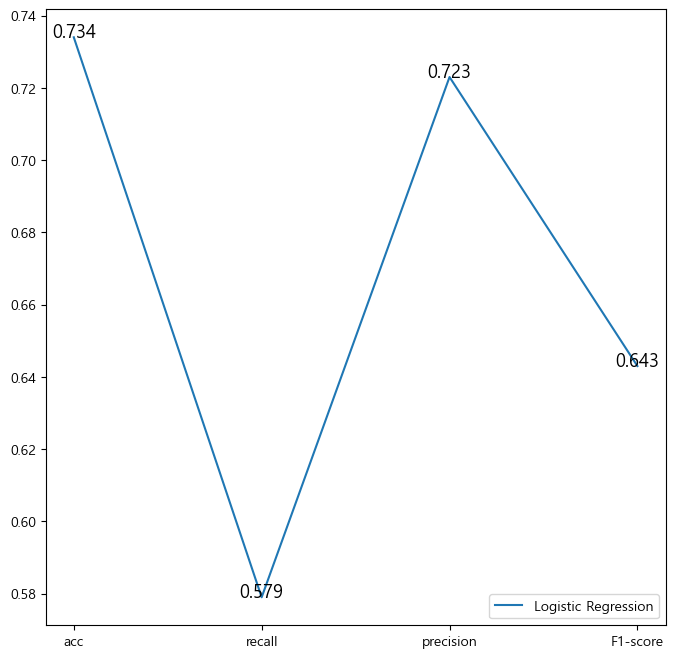

In [92]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=21)

model_lr.fit(x_train,y_train)

pred_lr=model_lr.predict(X_test)

result_view('Logistic Regression',pred_lr,Y_test)

### 2)KNN(K-Nearest Neighbors)

                       acc  recall  precision  F1-score
Logistic Regression  0.734   0.579      0.723     0.643
KNN                  0.718   0.607      0.678     0.641


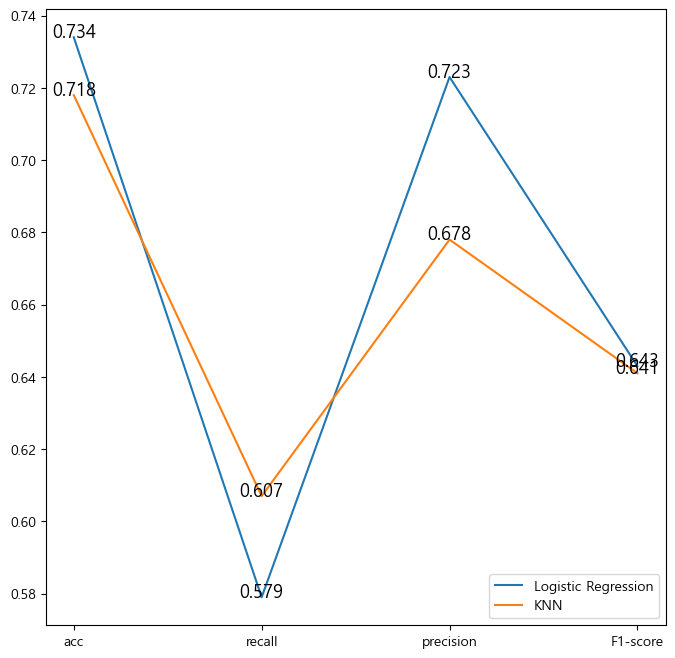

In [93]:
from sklearn.neighbors import KNeighborsClassifier

model_knn= KNeighborsClassifier()

model_knn.fit(x_train,y_train)
pred_knn=model_knn.predict(X_test)

result_view('KNN',pred_knn,Y_test)


### 3) SVM(Support Vector Machine)

                          acc  recall  precision  F1-score
Logistic Regression     0.734   0.579      0.723     0.643
Support Vector Machine  0.733   0.603      0.709     0.652
KNN                     0.718   0.607      0.678     0.641


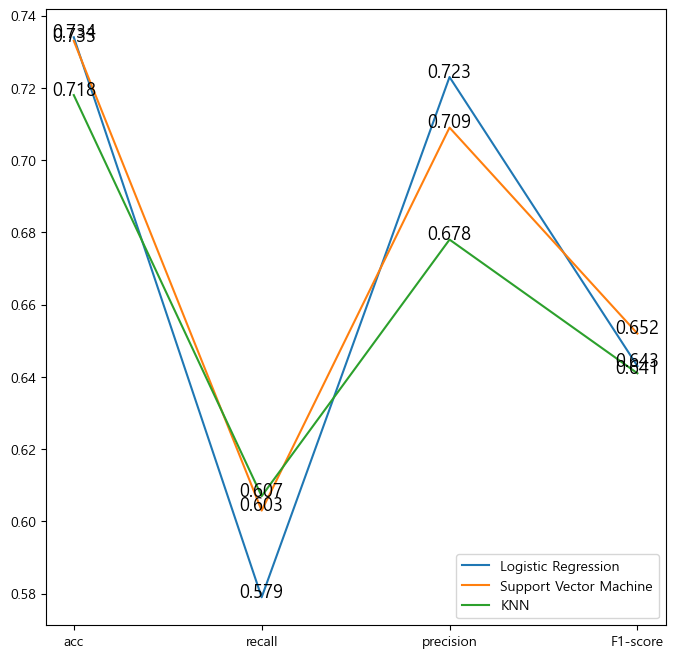

In [94]:
from sklearn.svm import SVC
model_svm= SVC(random_state=21)
model_svm.fit(x_train,y_train)
pred_svm=model_svm.predict(X_test)
result_view('Support Vector Machine',pred_svm,Y_test)


### 4) 의사결정트리(Decision Tree)

                          acc  recall  precision  F1-score
Decision Tree           0.746   0.624      0.724     0.670
Logistic Regression     0.734   0.579      0.723     0.643
Support Vector Machine  0.733   0.603      0.709     0.652
KNN                     0.718   0.607      0.678     0.641


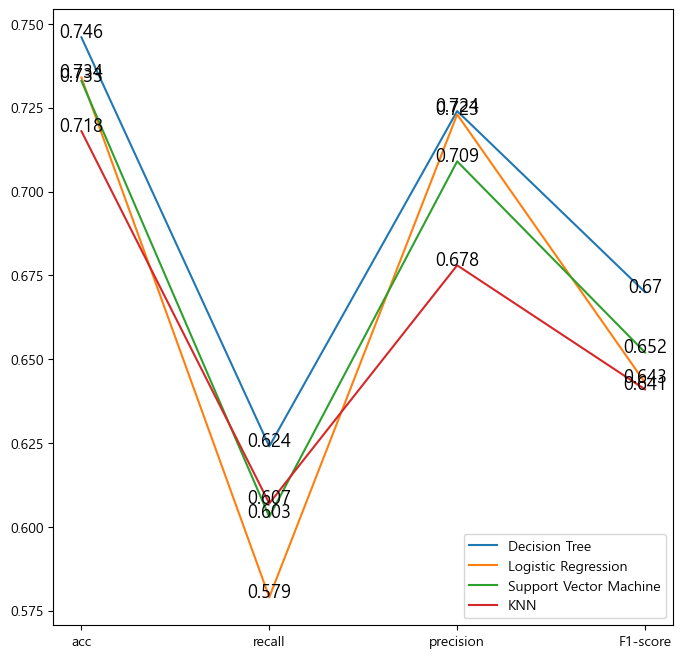

In [95]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features=None,
                                  max_depth=5,
                                  max_leaf_nodes=None,
                                  random_state=21
                                 )

model_dt.fit(x_train,y_train)
pred_dt=model_dt.predict(X_test)

result_view('Decision Tree',pred_dt,Y_test)

### 4) 의사결정트리(Decision Tree)

                          acc  recall  precision  F1-score
Random Forest           0.757   0.633      0.741     0.683
Decision Tree           0.746   0.624      0.724     0.670
Logistic Regression     0.734   0.579      0.723     0.643
Support Vector Machine  0.733   0.603      0.709     0.652
KNN                     0.718   0.607      0.678     0.641


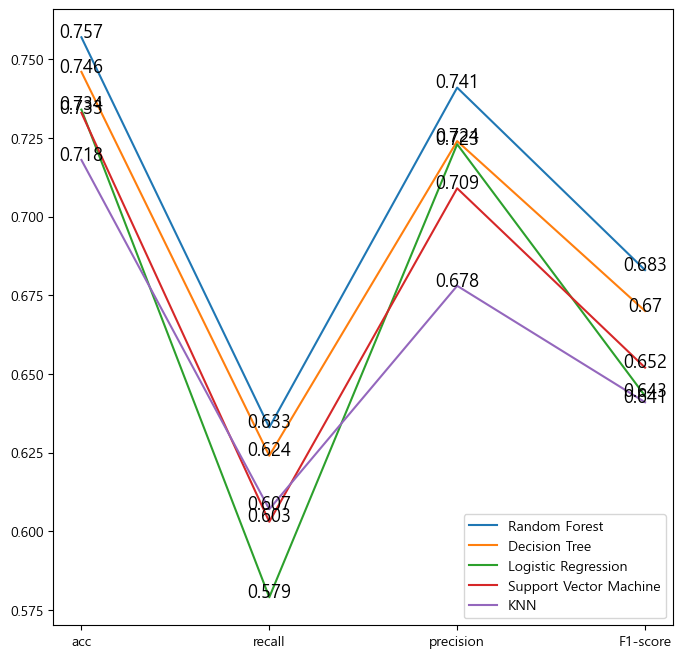

In [96]:
from sklearn.ensemble import RandomForestClassifier
model_rf= RandomForestClassifier(n_jobs=-1,n_estimators=100,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_features='auto',
                                 max_depth=None,
                                 max_leaf_nodes=None,
                                 random_state=21)

model_rf.fit(x_train,y_train)
pred_rf=model_rf.predict(X_test)
result_view('Random Forest',pred_rf,Y_test)


### 4) 의사결정트리(Decision Tree)

[0]	validation_0-logloss:0.66356
[1]	validation_0-logloss:0.63902
[2]	validation_0-logloss:0.61880
[3]	validation_0-logloss:0.60190
[4]	validation_0-logloss:0.58782
[5]	validation_0-logloss:0.57577
[6]	validation_0-logloss:0.56570
[7]	validation_0-logloss:0.55689
[8]	validation_0-logloss:0.54937
[9]	validation_0-logloss:0.54277
[10]	validation_0-logloss:0.53715
[11]	validation_0-logloss:0.53232
[12]	validation_0-logloss:0.52807
[13]	validation_0-logloss:0.52379
[14]	validation_0-logloss:0.52068
[15]	validation_0-logloss:0.51771
[16]	validation_0-logloss:0.51520
[17]	validation_0-logloss:0.51303
[18]	validation_0-logloss:0.51088
[19]	validation_0-logloss:0.50883
[20]	validation_0-logloss:0.50704
[21]	validation_0-logloss:0.50556
[22]	validation_0-logloss:0.50441
[23]	validation_0-logloss:0.50304
[24]	validation_0-logloss:0.50191
[25]	validation_0-logloss:0.50071
[26]	validation_0-logloss:0.49998
[27]	validation_0-logloss:0.49907
[28]	validation_0-logloss:0.49823
[29]	validation_0-loglos

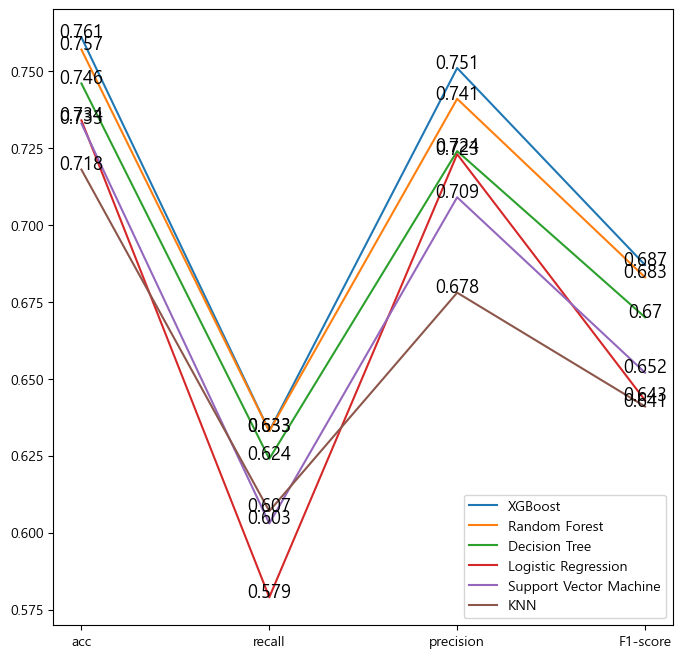

In [97]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(learning_rate=0.1,n_jobs=-1,n_estimators=500, random_state=21)

start=time.time()

eval_set = [(x_val, y_val)]

# logloss가 10회 개선되지 않으면 중단하도록 early stopping 설정하기
model_xgb.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

(time.time()-start)/60

pred_xgb=model_xgb.predict(X_test)
result_view('XGBoost',pred_xgb,Y_test) 


### 7) CatBoost

In [98]:
import time
start=time.time()

from catboost import CatBoostClassifier, Pool

cat = CatBoostClassifier(learning_rate=0.03, iterations=2000,random_state=21)

start=time.time()
# Pool 함수로 데이터셋 지정하기. 반드시 label을 지정해 주어야 함
train_dataset = Pool(data=x_train,label=y_train) #feature와 label 지정하기
eval_dataset = Pool(data=x_val,label=y_val) #feature와 label 지정하기

cat.fit(train_dataset, eval_set=eval_dataset, early_stopping_rounds=30)
(time.time()-start)/60

0:	learn: 0.6825267	test: 0.6824197	best: 0.6824197 (0)	total: 176ms	remaining: 5m 51s
1:	learn: 0.6730978	test: 0.6728398	best: 0.6728398 (1)	total: 184ms	remaining: 3m 3s
2:	learn: 0.6649256	test: 0.6645339	best: 0.6645339 (2)	total: 190ms	remaining: 2m 6s
3:	learn: 0.6567848	test: 0.6562214	best: 0.6562214 (3)	total: 197ms	remaining: 1m 38s
4:	learn: 0.6492709	test: 0.6486595	best: 0.6486595 (4)	total: 203ms	remaining: 1m 21s
5:	learn: 0.6415038	test: 0.6407122	best: 0.6407122 (5)	total: 209ms	remaining: 1m 9s
6:	learn: 0.6345954	test: 0.6336873	best: 0.6336873 (6)	total: 215ms	remaining: 1m 1s
7:	learn: 0.6280288	test: 0.6269954	best: 0.6269954 (7)	total: 221ms	remaining: 54.9s
8:	learn: 0.6218946	test: 0.6208144	best: 0.6208144 (8)	total: 226ms	remaining: 50.1s
9:	learn: 0.6164050	test: 0.6152800	best: 0.6152800 (9)	total: 232ms	remaining: 46.1s
10:	learn: 0.6109634	test: 0.6098003	best: 0.6098003 (10)	total: 237ms	remaining: 42.9s
11:	learn: 0.6055985	test: 0.6044045	best: 0.6044

0.1424170692761739

                          acc  recall  precision  F1-score
Cat Boost               0.763   0.642      0.749     0.691
XGBoost                 0.761   0.633      0.751     0.687
Random Forest           0.757   0.633      0.741     0.683
Decision Tree           0.746   0.624      0.724     0.670
Logistic Regression     0.734   0.579      0.723     0.643
Support Vector Machine  0.733   0.603      0.709     0.652
KNN                     0.718   0.607      0.678     0.641


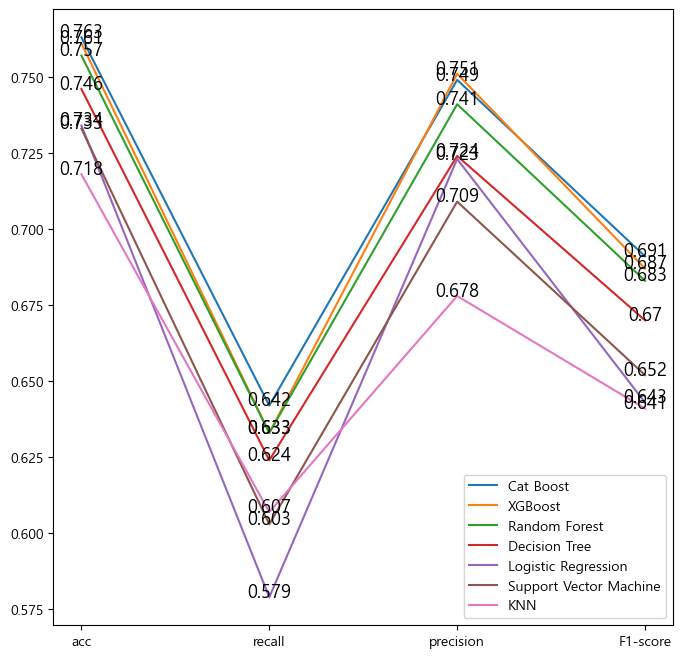

In [99]:
pred_cat = cat.predict(X_test)
result_view('Cat Boost',pred_cat,Y_test)

### **8) DNN(Deep Neural Network**

#### [Step 1. 라이브러리 불러오기]

In [100]:
# DNN 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

#### [Step 2. 모델 생성하기]

In [101]:
x_train.shape, y_train.shape #features 개수 확인하기

((41250, 26), (41250,))

초기화 함수initializer는 초기화 함수 사용
- 케라스 층layer의 파라미터 초기값을 어떤 방식으로 생성할 것인지를 결정합니다. 
- 모든 층에서 다 똑같은 것은 아니지만, 대부분의 경우 kernel_initializer와 bias_initializer 인자argument를 사용해서 가중치weight와 편향bias의 초기화 함수를 지정합니다.
  
- GlorotUniform 
    - Glorot 균등분포 방식으로 파라미터의 초기값을 생성합니다. 
    - Xavier 균등분포 방식이라고도 불리며, 가중치 텐서의 크기에 따라 값을 조절하는 방식의 하나입니다.
    - [-limit, limit]의 범위를 가진 균등분포로부터 값이 선택됩니다. 
    - 가중치 텐서의 입력 차원 크기를 fan_in, 출력 차원 크기를 fan_out이라고 할 때, limit은 sqrt(6 / (fan_in + fan_out))으로 구합니다.
    - 인자
        - seed: int. 무작위 생성에 사용할 시드를 정합니다. 기본값은 None입니다.

In [102]:
# 모델 구성하기
initializer = tf.keras.initializers.GlorotUniform(seed=10) #초기값 설정
dnn = Sequential()
dnn.add(Dense(8, activation='relu', input_shape=(26,),kernel_initializer=initializer))
dnn.add(Dropout(0.2))
dnn.add(Dense(2, activation='relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(1, activation='sigmoid')) #0,1로 분류되는 시그모이드이기 때문에

In [105]:
# 모델 확인하기
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 216       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 237 (948.00 Byte)
Trainable params: 237 (948.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
# 모델 컴파일 – 이진 분류 모델
dnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']) 

#### [Step 3. 모델 학습하기]

In [108]:
# Callback : 조기종료, 모델 저장하기
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [109]:
# val_loss 모니터링해서 성능이 5번 지나도록 좋아지지 않으면 조기 종료하기
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)


In [112]:
# val_loss 가장 낮은 값을 가질때마다 모델저장하기
check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True,
                              mode = 'min', save_weights_only=True)

In [113]:
# 모델 학습하기
history = dnn.fit(x=x_train, y=y_train, 
                  validation_data=(x_val, y_val),
                  epochs = 50,
                  batch_size =20,
                  verbose = 1,
                  callbacks = [early_stop, check_point])

Epoch 1/50
2002/2063 [============================>.] - ETA: 0s - loss: 0.6532 - accuracy: 0.6348
Epoch 1: val_loss improved from inf to 0.59951, saving model to best_model.h5
2063/2063 [==============================] - 3s 1ms/step - loss: 0.6521 - accuracy: 0.6356 - val_loss: 0.5995 - val_accuracy: 0.7113
Epoch 2/50
2053/2063 [============================>.] - ETA: 0s - loss: 0.6035 - accuracy: 0.6876
Epoch 2: val_loss improved from 0.59951 to 0.56734, saving model to best_model.h5
2063/2063 [==============================] - 2s 944us/step - loss: 0.6037 - accuracy: 0.6872 - val_loss: 0.5673 - val_accuracy: 0.7247
Epoch 3/50
2049/2063 [============================>.] - ETA: 0s - loss: 0.5931 - accuracy: 0.6960
Epoch 3: val_loss improved from 0.56734 to 0.56453, saving model to best_model.h5
2063/2063 [==============================] - 2s 905us/step - loss: 0.5933 - accuracy: 0.6960 - val_loss: 0.5645 - val_accuracy: 0.7203
Epoch 4/50
2003/2063 [============================>.] - ETA: 

#### [Step 4. 결과 검증하기]

In [118]:
dnn.predict(X_test)

  1/157 [..............................] - ETA: 2s

157/157 [==============================] - 0s 519us/step


array([[0.24898288],
       [0.3705174 ],
       [0.42961425],
       ...,
       [0.3577485 ],
       [0.7475404 ],
       [0.32834944]], dtype=float32)

  1/157 [..............................] - ETA: 2s

157/157 [==============================] - 0s 545us/step
                          acc  recall  precision  F1-score
Cat Boost               0.763   0.642      0.749     0.691
XGBoost                 0.761   0.633      0.751     0.687
Random Forest           0.757   0.633      0.741     0.683
Decision Tree           0.746   0.624      0.724     0.670
DNN                     0.736   0.533      0.757     0.626
Logistic Regression     0.734   0.579      0.723     0.643
Support Vector Machine  0.733   0.603      0.709     0.652
KNN                     0.718   0.607      0.678     0.641


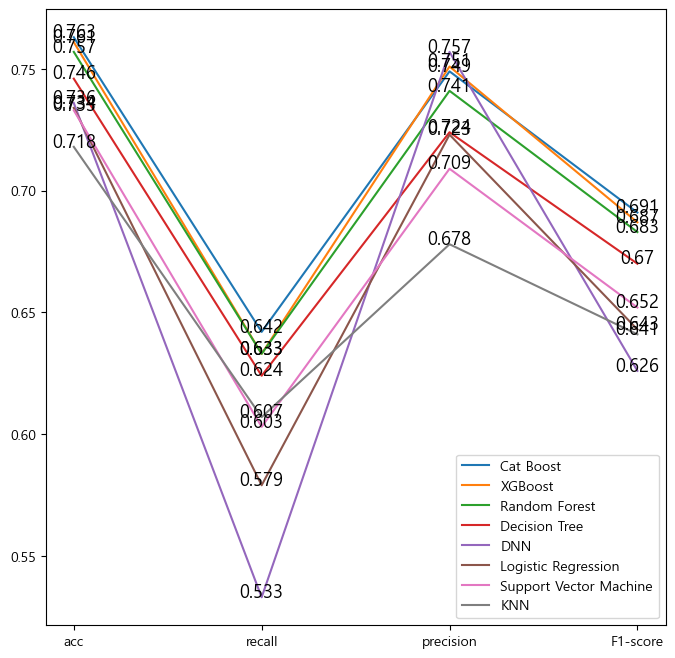

In [119]:
# 결과 예측하기
pred_dnn = (dnn.predict(X_test) > 0.5).astype("int32")
pred_dnn=pred_dnn.reshape(1,-1)[0]
result_view('DNN',pred_dnn,Y_test)

## 4. AI 모델의 평가하기

### 1) 혼동행렬

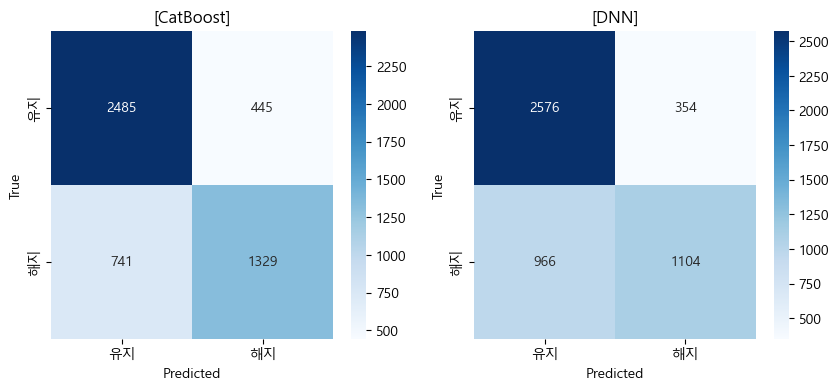

In [149]:

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

labels = ['유지', '해지']

ax[0].set_title('[CatBoost]')
sns.heatmap(confusion_matrix(Y_test, pred_cat), 
            ax=ax[0], annot=True, fmt='d', cmap=plt.cm.Blues,linecolor='black',
            xticklabels=labels, yticklabels=labels,)
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

ax[1].set_title('[DNN]')
sns.heatmap(confusion_matrix(Y_test, pred_dnn), ax=ax[1], 
            annot=True, fmt='d', cmap=plt.cm.Blues, linecolor='black',
            xticklabels=labels, yticklabels=labels,)
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.show()

In [145]:
# # confusion matrix를 그리기위한 함수를 정의하기
# def show_confusion_matrix(labels,y_true,y_pred,title):   
#     sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d',xticklabels=labels,yticklabels=labels,cmap=plt.cm.Blues,linecolor='black')
#     plt.text(1,2.3,'Predicted',size=15,ha='center')
#     plt.text(-0.3,1,'True',rotation=90,size=15,ha='center')
#     plt.title(title)
#     plt.show()
    
# labels=['유지','해지']

# # 정의된 함수를 활용하여 catboost와 DNN모델의 confusion matrix 그flrl
# show_confusion_matrix(labels,Y_test,pred_cat,'[CatBoost]'), show_confusion_matrix(labels,Y_test,pred_dnn,'[DNN]')

### 2) ROC와 AUC

In [150]:
# 패키지 불러오기
from sklearn.metrics import roc_curve, auc

# Parameter
# y_pred: 원핫인코딩된 2차원 이상(class수에 따라)의 numpy.array
# y_true: 실제 값
# y_label: label 값(list)
# ROC를 그려주는 함수

def plot_multiclass_roc(y_pred, y_true, y_label):
    
    # 빈 ditionary 생성하기
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # roc_curve()의 입력값으로 y_true의 가변수 생성하기
    y_true_dummies = pd.get_dummies(y_true, drop_first=False).values
    for i in range(len(y_label)):
        fpr[i], tpr[i], _ = roc_curve(y_true_dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 각 클래스에 대한 ROC계산하기
    fig, ax = plt.subplots(figsize=(17,10))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    
    for i in range(len(y_label)):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], y_label[i]))
        
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

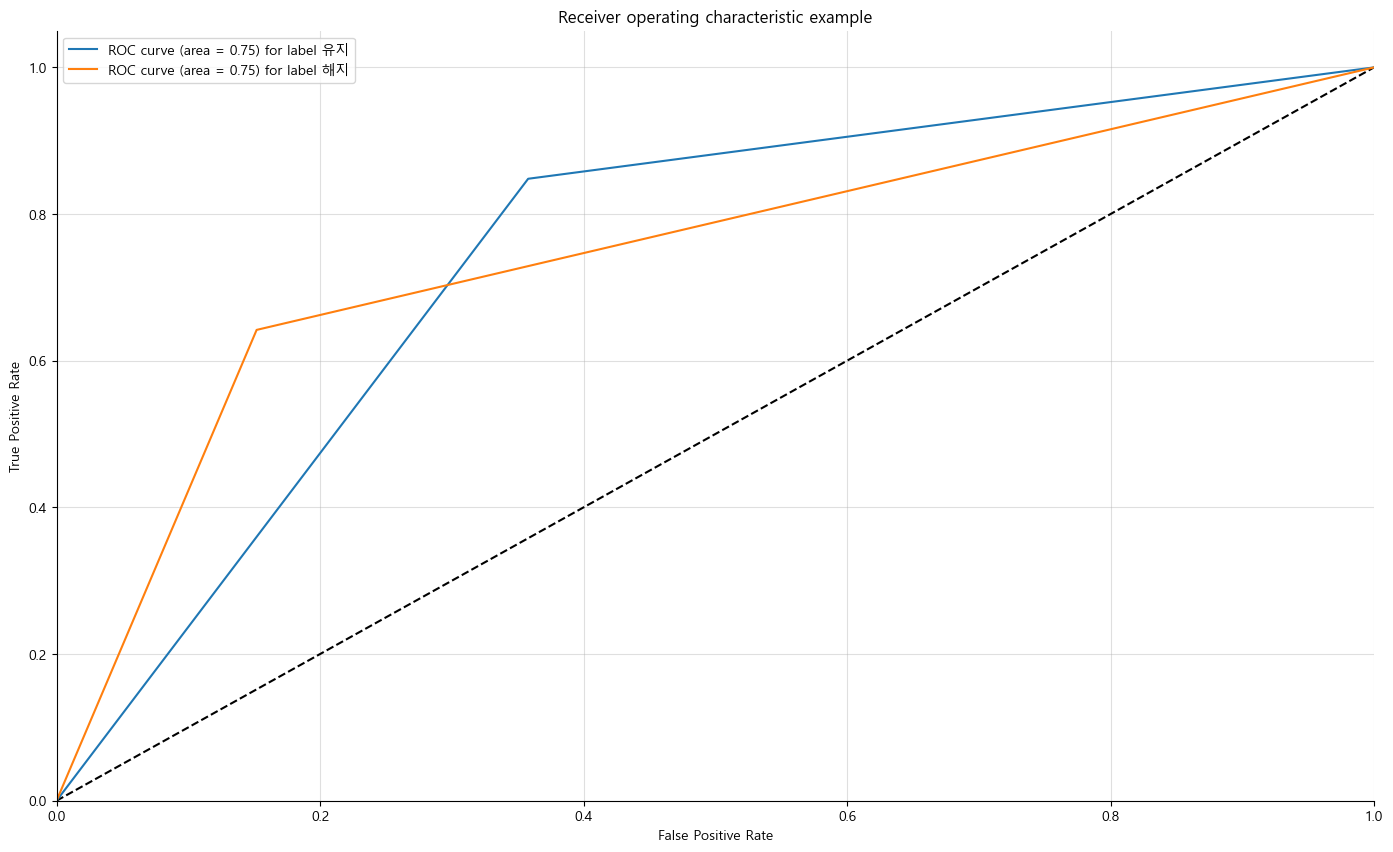

In [254]:
# labels 값은 Confusion Matrix에서 정한 값을 사용하기
plot_multiclass_roc(pd.get_dummies(pred_cat).to_numpy(), Y_test, labels)

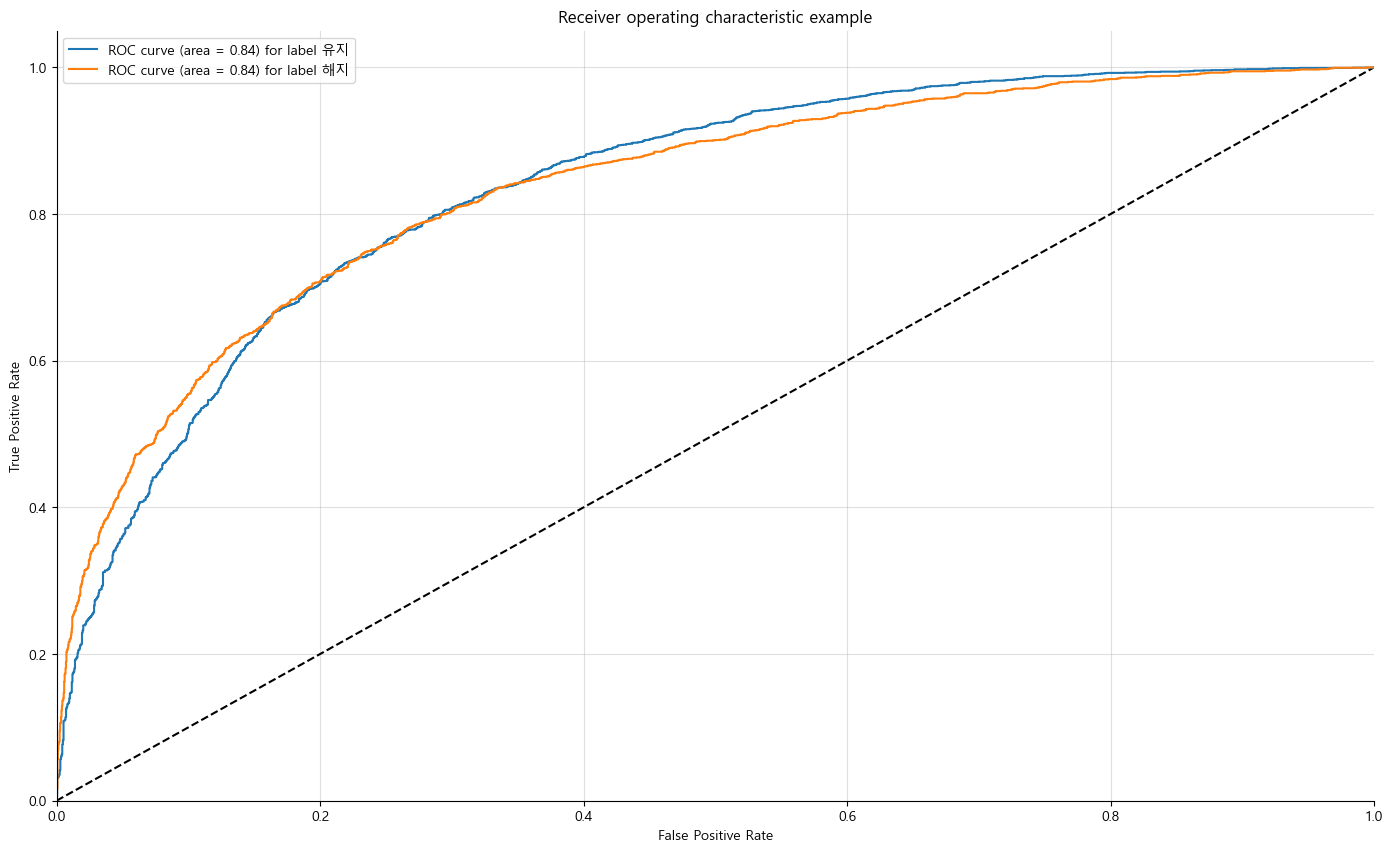

In [255]:
pred_cat_proba=cat.predict_proba(X_test)
plot_multiclass_roc(pred_cat_proba, Y_test, labels)